# BUS SCHEDULE PROGRAM V4.2
###### Creado por Danna y Ricardo

In [1]:
import pandas as pd
import csv
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
from matplotlib.dates import DateFormatter
import math

### CONTENIDO
- [Panel de control](#Panel_de_control)
- [Rol completo](#Rol_completo)
- [Plots por ruta](#Plots_por_ruta)
- [Buses innecesarios](#Buses_innecesarios)
- [Proceso de guardado (compatibilidad)](#Proceso_guardado)
- [Tarifa GDMTH](#GDMTH)
- [Overlaps](#Overlaps)

###### Funciones propias

In [2]:
# Devuelve el nombre completo de la avrebiación por ruta (HAR -> Harbor)
def func_nombres(ruta):   # Intentar con funcion np.where
    ordes = ruta.split('_')
    if ordes[0] in nombres.keys() :
        nombre = nombres[ordes[0]]
    elif ordes[1] in nombres.keys() :
        nombre = nombres[ordes[1]]
    return nombre
# Calcula la diferencia entre un bus y otro para un paradero específico
def frecuencias(df, x): 
    try:
        return df[x.name] - df[x.name-1]
    except:
        return np.nan
# Determina si un bus pasa demasiado frecuente o no (problemático/eliminable)
def comparaciones(linea):
    if linea['frecuencia']<0.66*f :#or linea['frecuencia']>1.33*f:
        return [ df_analisis['bus'][linea.name-1], linea['bus'] ]
    else :
        return [np.nan, np.nan]
# Crea una columna de salida (fin carga) según el tiempo de carga en la estación
def finCarga(time, wait) :
    return (time + dt.timedelta(minutes=wait)).strftime('%H:%M')
# Devuelve el tiempo de espera (estancia) en función de la hora pico o valle
def estancias(hora) :
    return Estancias[horas_pico.loc[hora.hour].values[0]]
# Devuelve el porcentaje final por desgaste de la batería según los km recorridos
def desgaste_batt() :
    return (max(schedule[i][9],schedule[i][10])*batt - (km[route]*rend)) / batt
def time2float(timeDelta) :
    return timeDelta.total_seconds()/3600
# Procedimiento de carga
def carga_batt() :
    tiempo_carga = Estancias[2]
    cargador = cargadores[ruta.split('_')[1]][0]
    P_carga = cargadores[ruta.split('_')[1]][1]
    # Si la carga de 15min excede la carga máxima, reajusta el tiempo y la corta
    if (soc_llegada*batt + P_carga*tiempo_carga/60)/batt < carga_max :
        soc_salida = (soc_llegada*batt + P_carga*tiempo_carga/60)/batt
        estancia = Estancias[2]
    else :
        soc_salida = carga_max
        estancia = (soc_salida-soc_llegada)*batt/P_carga*60    
    return [tiempo_carga, cargador, P_carga, soc_salida, estancia]
# Hace el cambio de origen-destino considerando cargadores intermedios y distancias fraccionarias
def or_des_switch(last_route) :
    s = or_des[route].index(last_route) + 1 # Posición actual
    if s >= len(or_des[route]) :
        s = 0
    ruta = or_des[route][s]
    tiempo_ruta = tiempos_rutas[route][s]
    next_tiempo_ruta = tiempos_rutas[route][0] if (s+1)>=len(or_des[route]) else tiempos_rutas[route][s+1]
    km = kmts_rutas[route][s]
    next_km = kmts_rutas[route][0] if (s+1)>=len(or_des[route]) else kmts_rutas[route][s+1]
    return [ruta, tiempo_ruta, next_tiempo_ruta, km, next_km]
# Realiza el guardado de la información actual para interrumpir el programa
def guardado_forzado():
    tiempo_carga, cargador, soc_salida, P_carga = 0, '', np.nan, np.nan
    fila = [ bus,ruta,hora_sale,hora_llega,km,km_acum,estancias(hora_llega),#[route][k-1][i+1],
             tiempo_carga,cargador,soc_llegada,soc_salida,P_carga,str(tiempo_ruta).split(' ')[2],empty]
    return fila
# Función de parámetro de carga (Tarifa GDMTH)
def tiempos_carga(llegada, salida, carga) :
    # Tiempo de carga
    tiempo_carga = round(carga/P_carga_noct,3)   # 60kW (potencia de cargador compartido)
    horas, minutos = int( round(np.floor(tiempo_carga),0) ), int( round((tiempo_carga%1)*60,0) )
    if minutos==60 :
        horas += 1; minutos = 0
    tiempo_carga = dt.timedelta(hours=horas, minutes=minutos)#dt.datetime.strptime(str(horas)+':'+str(minutos), '%H:%M')#.strftime("%H:%M")
    # Hora final de carga
    hora_fin = llegada + tiempo_carga
    return [tiempo_carga, hora_fin, hora_fin.time()<salida.time()]

## Panel de control  <a id='Panel_de_control'></a>

In [3]:
# PARÁMETROS TÉCNICOS DEL AUTOBÚS
batt = 475   # kWh (LFP)
rend = 2   # kWh/km
P_carga_noct = 120/2  #kW (compartidos)  |  Opciones: 120!, 160 y 180 kW

descarga_max = 0.1
carga_max = 0.90

# CARGADORES Y PANTÓGRAFOS
# Opciones pantografos: 150, 300 y 450 kW
Pantographs = True   # Condición de carga con pantógrafos
cargadores = {'KAN':['PLAZA ORIENTE', 300],    # Nota: UMA, POX, ING, TEY, KAN
              'UMA':['UMAN', 300], 
              'TEY':['TEYA', 300], 
              'POX':['UMAN', 300], 
              'PLA':['CENTRO', 300], 
              'HAR':['INGENIERIA', 300],
              'CCO':['CIRCUITO', 300]}

nombres = {'KAN':'Kanasin', 'UMA':'Uman', 'TEY':'Teya', 'POX':'Pox', 'HAR':'Harbor'}
colores = {'KAN':'red', 'UMA':'orange', 'TEY':'purple', 'CCO':'green', 'POX':'green', 'HAR':'blue'}

# CONTROL DE HORARIOS
salida_inicial = dt.datetime.strptime('5:30', '%H:%M')
salida_max = dt.datetime.strptime('23:30', '%H:%M')    # Hora máxima para terminar una ruta
inicio_hora_punta = dt.datetime.strptime('17:45', '%H:%M')  # Considerando 15min de carga 
fin_hora_punta = dt.datetime.strptime('22:00', '%H:%M')

horas_pico = pd.DataFrame(data=[0,1,1,1,1,1,0,0,0,0,0,0,0,1,1,1,1,1,0,0],index=range(4,24), columns=['Horario punta'])

# FORMATO DE GUARDADO
columnas = ['bus','ruta','Salida','Llegada','km','km acum','T_espera','T_carga','Cargador','SoC_llegada','SoC_salida','Potencia_cargador','Tiempo recorrido','Vacío']
#             0      1      2         3       4      5         6          7         8            9            10               11                 12            13

    
# VARIABLES GENERALES Y OPERATIVAS
ChargeTrigg = {'Harbor': [0.52,0.07] , 'Kanasin': [0.55,0.15], 'Uman':[0.62,0.14], 'Teya':[0.65,0.1], 'Pox': [0.6,0.05]}
buses = {'Harbor':range(1,8), 'Kanasin':range(8,14), 'Uman':range(14,23), 'Teya':range(23,27), 'Pox':range(27,33)}
bus_ruta_inversa = {'Harbor':[4,4,4], 'Kanasin':[12,5,11], 'Uman':[21,8,18], 'Teya':[25,3,25], 'Pox':[30,4,30]}

kmts_rutas = {'Harbor':[12.25, 12.25], 'Kanasin':[11.95, 11.95], 'Teya':[14.55, 14.55],
              'Uman':[20.95, 5.0, 5.0, 20.95], # Total ruta: 25.95 km
              'Pox':[6.0, 20.95, 5.0, 5.0, 20.95, 6.0], # Total ruta: 31.95 km
              'Totales': dict(zip(['Harbor','Kanasin','Uman','Teya','Pox'],
                                  [12.25,11.95,25.95,14.55,31.95]))}

tiempos_rutas = {'Harbor': pd.to_timedelta([47, 47], unit='minutes'),  # más 10 min paradas, v=20 km/h
                 'Kanasin': pd.to_timedelta([60, 60], unit='minutes'), # más 16 min paradas, v=20 km/h 
                 'Uman': pd.to_timedelta([56.5, 13.5, 13.15, 56.5], unit='minutes'),  # Total: 70min, con 10 min paradas| paraderos no confirmados, v=25 km/h PENDIENTE ESTANCIA
                 'Teya': pd.to_timedelta([35, 35], unit='minutes'),  # directa, v=35 km/h
                 'Pox': pd.to_timedelta([15, 52.5, 12.5, 12.5, 52.5, 15], unit='minutes'),  # Total: 80min, directa, v=35 km/h
                 'Totales': dict(zip(['Kanasin','Uman','Teya','Pox','Harbor'], 
                                     pd.to_timedelta([60,70,35,80,47], unit='minutes')))}
                 
frec = {'Harbor': pd.to_timedelta(15, unit='minutes'),
        'Kanasin': pd.to_timedelta(15, unit='minutes'),
        'Uman':   pd.to_timedelta(15, unit='minutes'),
        'Teya':   pd.to_timedelta(60, unit='minutes'),
        'Pox':    pd.to_timedelta(60, unit='minutes')}

#Estancias: Normal | Pico | T_carga
Estancias = [10, 5, 15]

cargas_forzadas = {25:[2], 31:[3], 6:[4,9], 14:[5], 12:[3]}
no_carga_en_PLA = [] # Rutas que no se deben cargar en el Centro (PLA)

or_des = {'Harbor': ['HAR_PLA', 'PLA_HAR'], 'Kanasin': ['KAN_PLA', 'PLA_KAN'], 
          'Uman': ['UMA_CCO', 'CCO_PLA', 'PLA_CCO', 'CCO_UMA'], 'Teya': ['TEY_PLA', 'PLA_TEY'], 
          'Pox':['POX_UMA', 'UMA_CCO', 'CCO_PLA', 'PLA_CCO', 'CCO_UMA', 'UMA_POX']}

### ROL COMPLETO <a id='Rol_completo'></a>

Controlled charge bus 6 , iteration: 4 , time: 11:12:00
Controlled charge bus 6 , iteration: 9 , time: 16:02:00
Controlled charge bus 12 , iteration: 3 , time: 10:50:00
Controlled charge bus 14 , iteration: 5 , time: 09:42:48
Controlled charge bus 25 , iteration: 2 , time: 08:05:00
Controlled charge bus 31 , iteration: 3 , time: 09:17:30


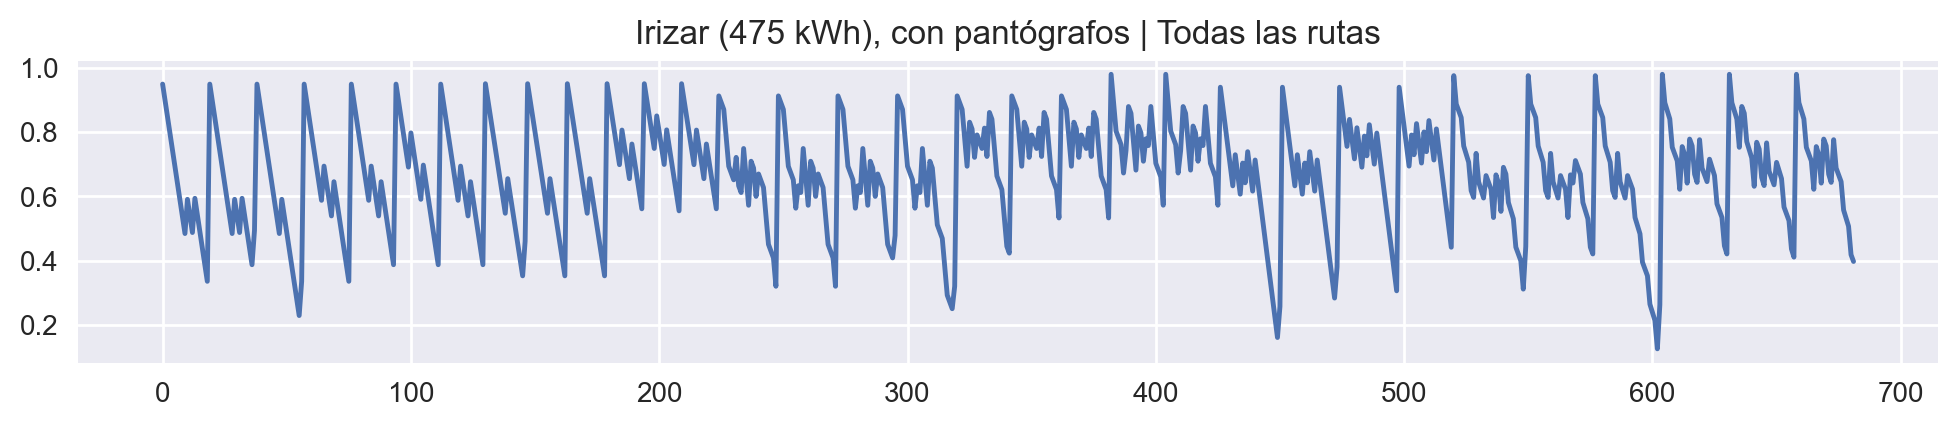

In [5]:
# Creación del programa
df_route = pd.DataFrame()

for route in ['Harbor','Kanasin','Uman','Teya','Pox']:
    for k, bus in enumerate(buses[route],1):
        # PARÁMETROS INICIALES
        if route == 'Kanasin' : # Ruta inversa (Únicamente la ruta de Kanasín tiene inversa vacía)
            Or_Des = or_des[route][1]
            if bus < bus_ruta_inversa[route][0] : # Ruta no inversa (sale en KAN pero inicia vacío en PLA)
                arrival = salida_inicial+(k-1)*frec[route]
                depart = arrival - tiempos_rutas[route][or_des[route].index(Or_Des)]
                empty = True
            else : # Ruta inversa (sale de PLA)
                depart = salida_inicial+(k-bus_ruta_inversa[route][1])*frec[route]
                arrival = depart + tiempos_rutas[route][or_des[route].index(Or_Des)]
                empty = False
        else :  # Para todas las otras rutas
            if bus < bus_ruta_inversa[route][0] : # Ruta no inversa (sale del extremo)
                depart = salida_inicial+(k-1)*frec[route]
                Or_Des = or_des[route][0]
            else : # Ruta inversa (sale de PLA)
                depart = salida_inicial+(k-bus_ruta_inversa[route][1])*frec[route]
                if route == 'Pox' :
                    Or_Des = or_des[route][3]
                elif route == 'Uman' :
                    Or_Des = or_des[route][2]
                else :
                    Or_Des = or_des[route][1]
            arrival = depart + tiempos_rutas[route][or_des[route].index(Or_Des)]
            empty = False

        # Primera línea generadora del rol por autobús
        ruta, tiempo_ruta, next_tiempo_ruta, km, next_km = or_des_switch(or_des[route][or_des[route].index(Or_Des)-1]) # Ajuste porque la fn adelanta una posición
        schedule = [[ bus, ruta, depart, arrival, km, km, estancias(arrival), 0, '',
                     (batt-(km*rend))/batt, np.nan, np.nan, str(tiempo_ruta).split(' ')[2], empty ]]

        soc_llegada, soc_salida = schedule[0][9:11]
        hora_llega = dt.datetime.strptime('1:30', '%H:%M')
        i, empty = 0, False # i es el iterador inicial, refiere a la línea anterior a la actual
        
        # PROGRAMA GENERADOR
        # Mientras aún haya tiempo de dar otra vuelta y esa vuelta no lo descargue más allá de la 
        # profundidad de descarga máxima (para rutas sin pantógrafo)
        while(hora_llega+next_tiempo_ruta<salida_max and np.nanmax([soc_llegada, soc_salida])-(next_km*rend)/batt > descarga_max):
            # Switching del origen-destino
            ruta, tiempo_ruta, next_tiempo_ruta, km, next_km = or_des_switch(schedule[i][1])
            # Datos del evento anterior 
            hora_sale = schedule[i][3] + pd.to_timedelta(max(schedule[i][6], schedule[i][7]), unit='minutes')
            hora_llega = hora_sale + tiempo_ruta
            km_acum = schedule[i][5] + km

            if Pantographs == True:  # PROTOCOLO DE CARGA (con pantógrafos)
                # Si en el evento anterior no cargó, la descarga actual se toma con el porcentaje habitual, si no, toma el % cargado
                soc_llegada = (schedule[i][9]*batt-(km*rend))/batt if np.isnan(schedule[i][10]) else \
                              (schedule[i][10]*batt-(km*rend))/batt 
                
                # Trigger condicional para rutas inversas
                TrigerCarga = ChargeTrigg[route][0] if bus<bus_ruta_inversa[route][2] else ChargeTrigg[route][0] + ChargeTrigg[route][1]
                # Si necesita cargarse, se encuentra en un punto de carga y no se encuentra en horario punta
                if soc_llegada<TrigerCarga and ruta.split('_')[1] in cargadores.keys() and (hora_llega<inicio_hora_punta or hora_llega>fin_hora_punta) :
                    # Si ya no dará otra vuelta, no es necesario cargar | Rutas que no cargan en la Plancha (Centro) 
                    if (hora_llega+next_tiempo_ruta>salida_max) or (ruta.split('_')[-1]=='PLA' and route in no_carga_en_PLA) :
                        schedule.append(guardado_forzado())
                        break # Termina todo el evento, por lo que se guarda de una vez
                    # Sale de horario punta, quiere cargar pero pertenece a ruta inversa
                    elif hora_llega.hour==22 and bus>=bus_ruta_inversa[route][2]:
                        # Si en la siguiente vuelta la batería no cae debajo del límite mínimo, se niega la recarga para aligerar congestión
                        if (soc_llegada*batt-(next_km*rend))/batt > descarga_max :
                            schedule.append(guardado_forzado())
                            break # Termina todo el evento, por lo que se guarda de una vez
                        else : # Se le permite cargar saliendo de horario punta
                            tiempo_carga, cargador, P_carga, soc_salida, estancia = carga_batt()
                    else : # Proceso de carga normal
                        tiempo_carga, cargador, P_carga, soc_salida, estancia = carga_batt()
    
                    
                else :  # No es necesario cargar o no se puede cargar
                    # Si la siguiente llegada cae en punta y no te encuentras en horario punta en este instante
                    next_arrival = hora_llega+next_tiempo_ruta + pd.to_timedelta(10, unit='minutes')
                    # El siguiente arribo va a ser en horario punta y estás justo antes de entrar a hora punta
                    if (next_arrival>inicio_hora_punta and next_arrival<fin_hora_punta) and (hora_llega<inicio_hora_punta) :
                        # Predicción de la carga durante horario punta hasta el final
                        m = (((soc_llegada*batt-(kmts_rutas['Totales'][route]*rend))/batt) - soc_llegada) / time2float(tiempos_rutas['Totales'][route]+pd.to_timedelta(5, unit='minutes'))
                        x_carga = time2float(fin_hora_punta-hora_llega)*m + soc_llegada
                        if x_carga < 0.2 :
                            tiempo_carga, cargador, P_carga, soc_salida, estancia = carga_batt()
                        else :
                            tiempo_carga, cargador, soc_salida, P_carga = 0, '', np.nan, np.nan
                            estancia = estancias(hora_llega)
                    # Crea un evento forzado (controlado) de carga
                    elif bus in cargas_forzadas.keys() and i in cargas_forzadas[bus] :
                        print('Controlled charge bus', bus, ', iteration:', i, ', time:', hora_llega.time())
                        tiempo_carga, cargador, P_carga, soc_salida, estancia = carga_batt()
                    # Crea un evento vacío de carga (no carga)
                    else :
                        tiempo_carga, cargador, soc_salida, P_carga = 0, '', np.nan, np.nan
                        estancia = estancias(hora_llega)
                        
            else:  # PROTOCOLO DE DESCARGA (sin pantógrafos)
                soc_llegada = (schedule[i][9]*batt-(km*rend))/batt
                tiempo_carga, cargador, soc_salida, P_carga = 0, '', np.nan, np.nan
                estancia = estancias(hora_llega)
            
            # Creamos el evento actual
            fila = [ bus, ruta, hora_sale, hora_llega, km, km_acum, estancia, tiempo_carga,
                    cargador, soc_llegada, soc_salida, P_carga, str(tiempo_ruta).split(' ')[2], empty]
            schedule.append(fila) #; print(i, schedule[-1][:2])
            i += 1
            
        # Caso Poxila y Uman no pueden terminar en CCO | Pox tampoco puede terminar en UMA
        ultimo_reg = schedule[-1][1] #; print('Ultimo registro', schedule[-1][:2])
        if ultimo_reg in ['POX_UMA','PLA_CCO'] or (route=='Uman' and ultimo_reg=='UMA_CCO'):
            schedule = schedule[:-1]
            #print('Debug| Termina en:', schedule[-1][:2], schedule[-1][1].split('_')[1])
        elif route=='Pox' and ultimo_reg in ['UMA_CCO','CCO_UMA'] :
            schedule = schedule[:-2]
            #print('Debug2| Termina en:', schedule[-1][:2], schedule[-1][1].split('_')[1])
        # Corrobora que no cargue en la última llegada
        if schedule[-1][0] != '' :
            schedule[-1][6:12] = [10,0,'',schedule[-1][9],np.nan,np.nan]
        # Guarda los datos en un dataframe del rol para un solo bus
        df_bus_individual = pd.DataFrame(schedule, columns=columnas)
        df_route = pd.concat([df_route, df_bus_individual], ignore_index=True) 

plt.figure(figsize=(12,2), dpi=200)
plt.title('Irizar ('+ str(batt) + ' kWh), con pantógrafos | Todas las rutas') if Pantographs == True else \
        plt.title('Attivi ('+ str(batt) + ' kWh), sin recargas | Todas las rutas')
df_route['SoC_llegada'].plot()#.set_index('Llegada').sort_values(by='Llegada')['SoC_llegada'].plot()
#plt.legend(); plt.ylim([0.1, 1])
plt.style.use('seaborn')
plt.show()

[Panel de control](#Panel_de_control)     
[Proceso de guardado (compatibilidad)](#Proceso_guardado)   
[Tarifa GDMTH](#GDMTH)

In [7]:
df_route[(df_route.ruta.isin(or_des['Teya']))].tail(4)#&(df_route.Cargador!='')].sort_values('Llegada').tail(20)

,bus,ruta,Salida,Llegada,km,km acum,T_espera,T_carga,Cargador,SoC_llegada,SoC_salida,Potencia_cargador,Tiempo recorrido,Vacío
516,26,PLA_TEY,1900-01-01 19:50:00,1900-01-01 20:25:00,14.55,276.45,5.0,0,,0.625474,NaN,NaN,00:35:00,False
517,26,TEY_PLA,1900-01-01 20:30:00,1900-01-01 21:05:00,14.55,291.00,5.0,0,,0.564211,NaN,NaN,00:35:00,False
518,26,PLA_TEY,1900-01-01 21:10:00,1900-01-01 21:45:00,14.55,305.55,5.0,0,,0.502947,NaN,NaN,00:35:00,False
519,26,TEY_PLA,1900-01-01 21:50:00,1900-01-01 22:25:00,14.55,320.10,10.0,0,,0.441684,NaN,NaN,00:35:00,False


### Plots por ruta <a id='Plots_por_ruta'></a>

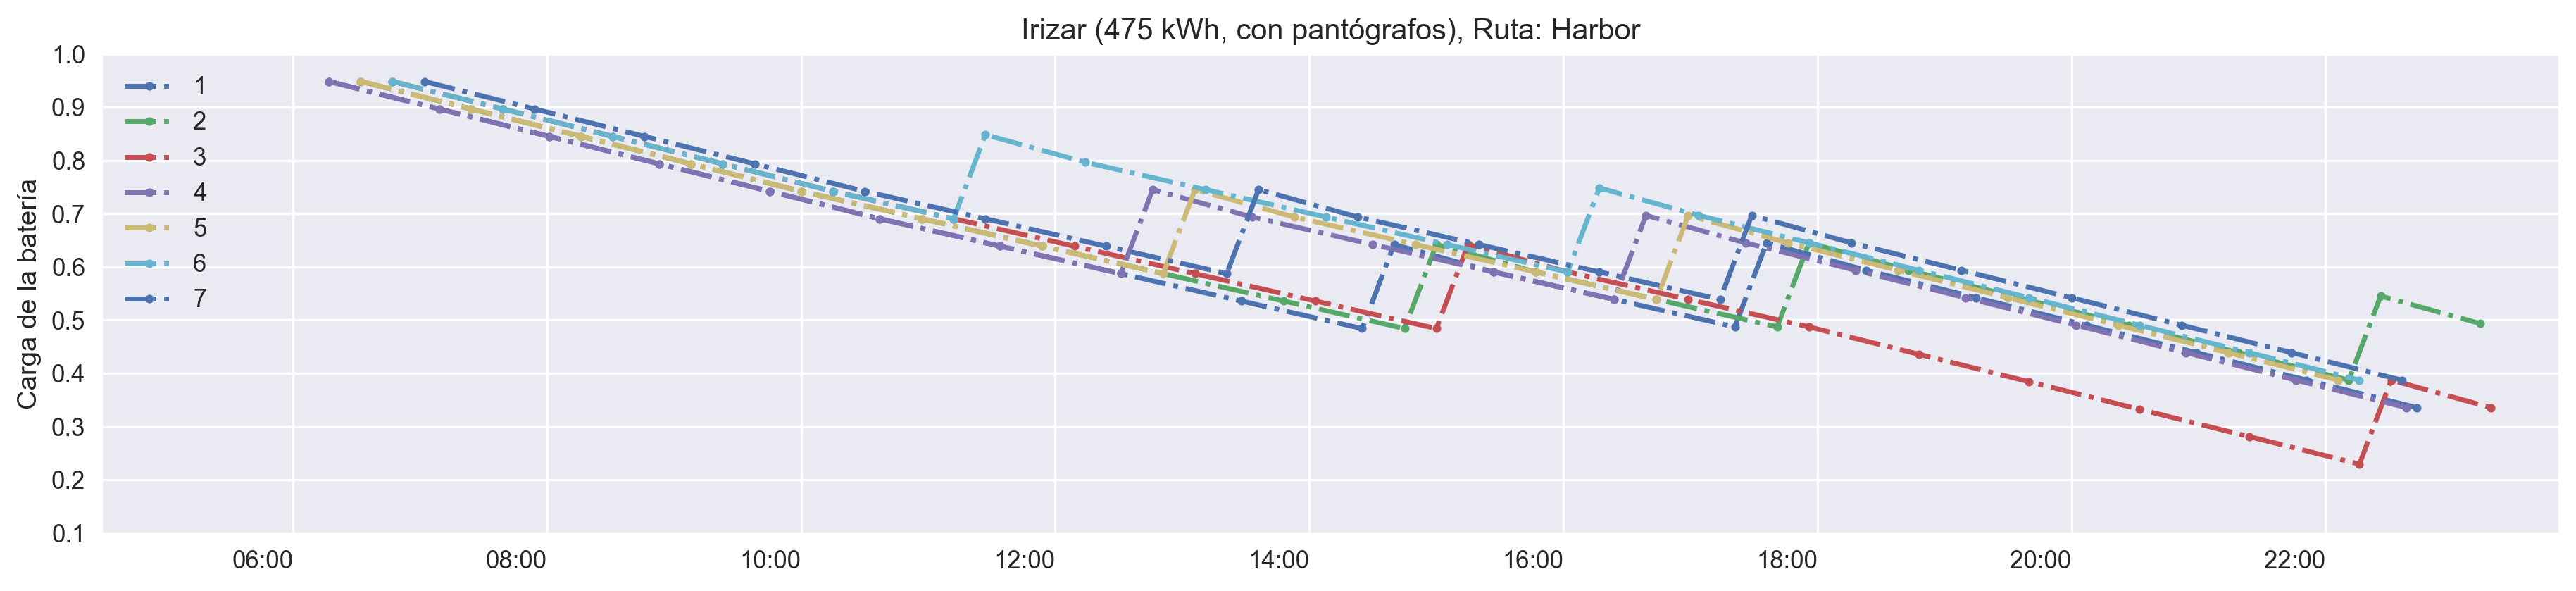

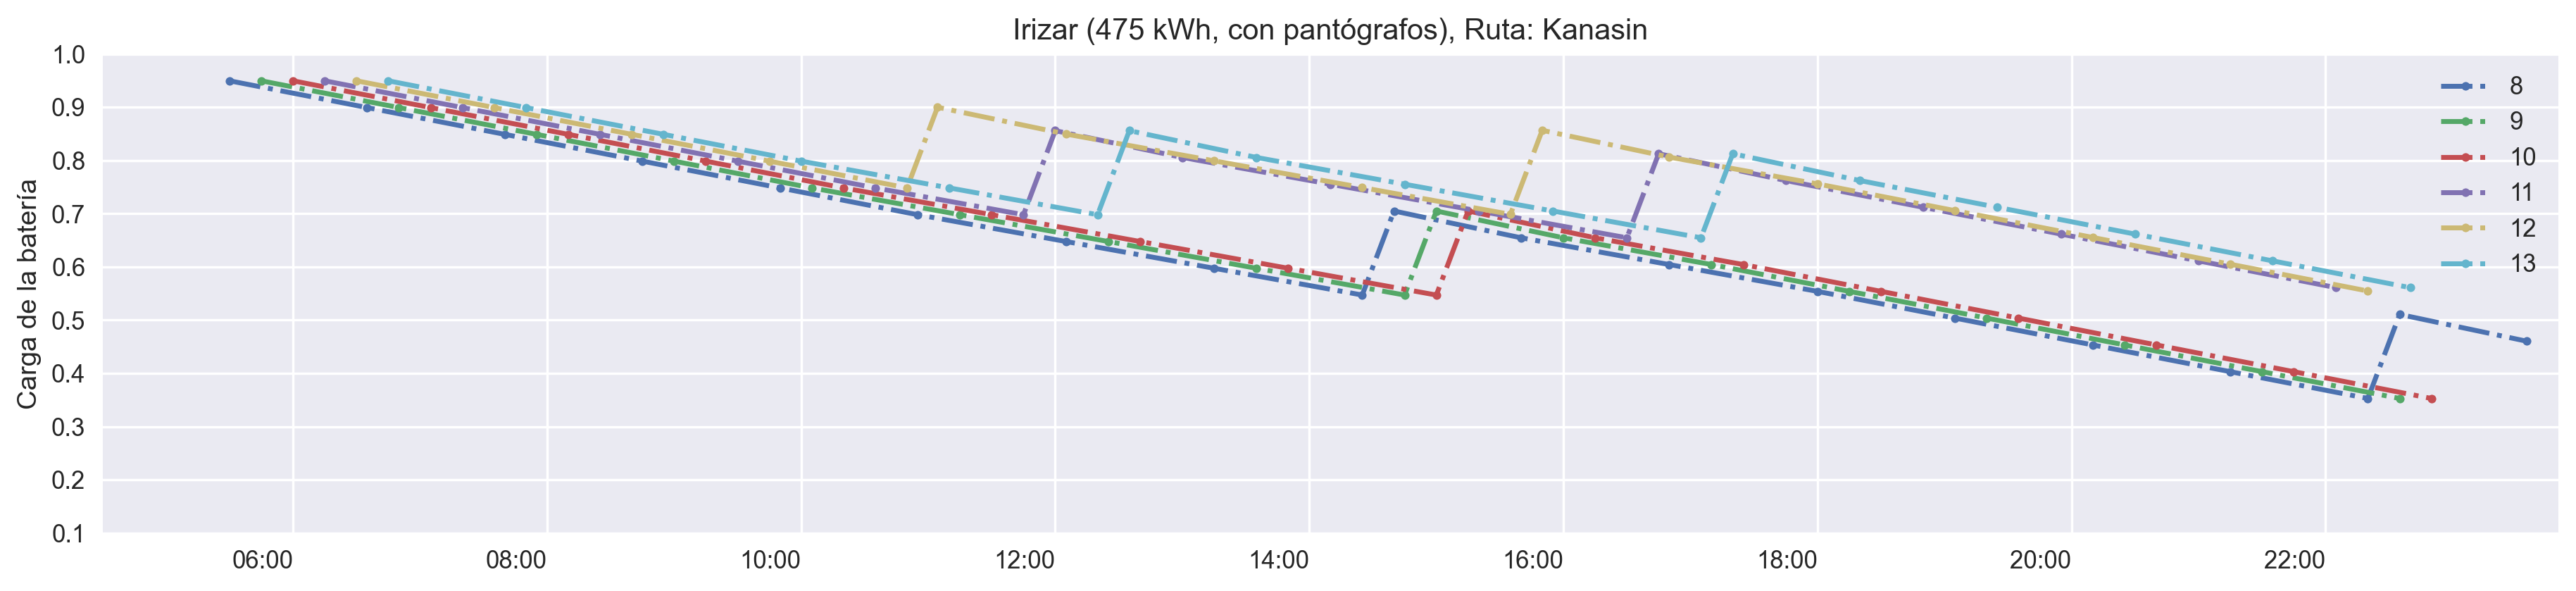

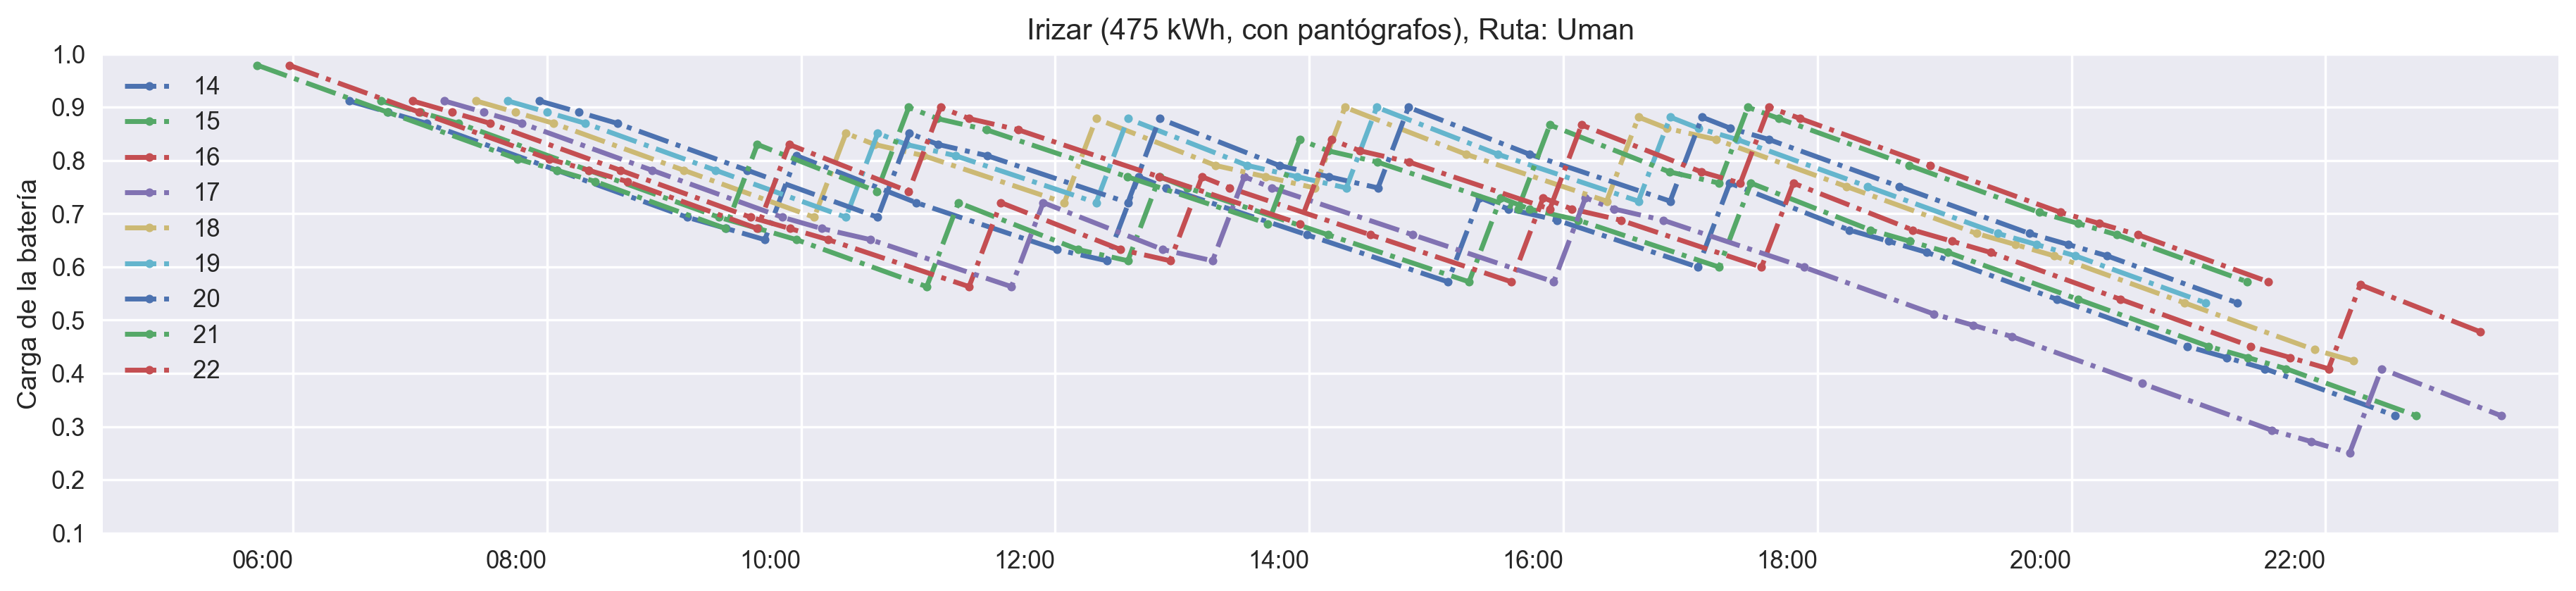

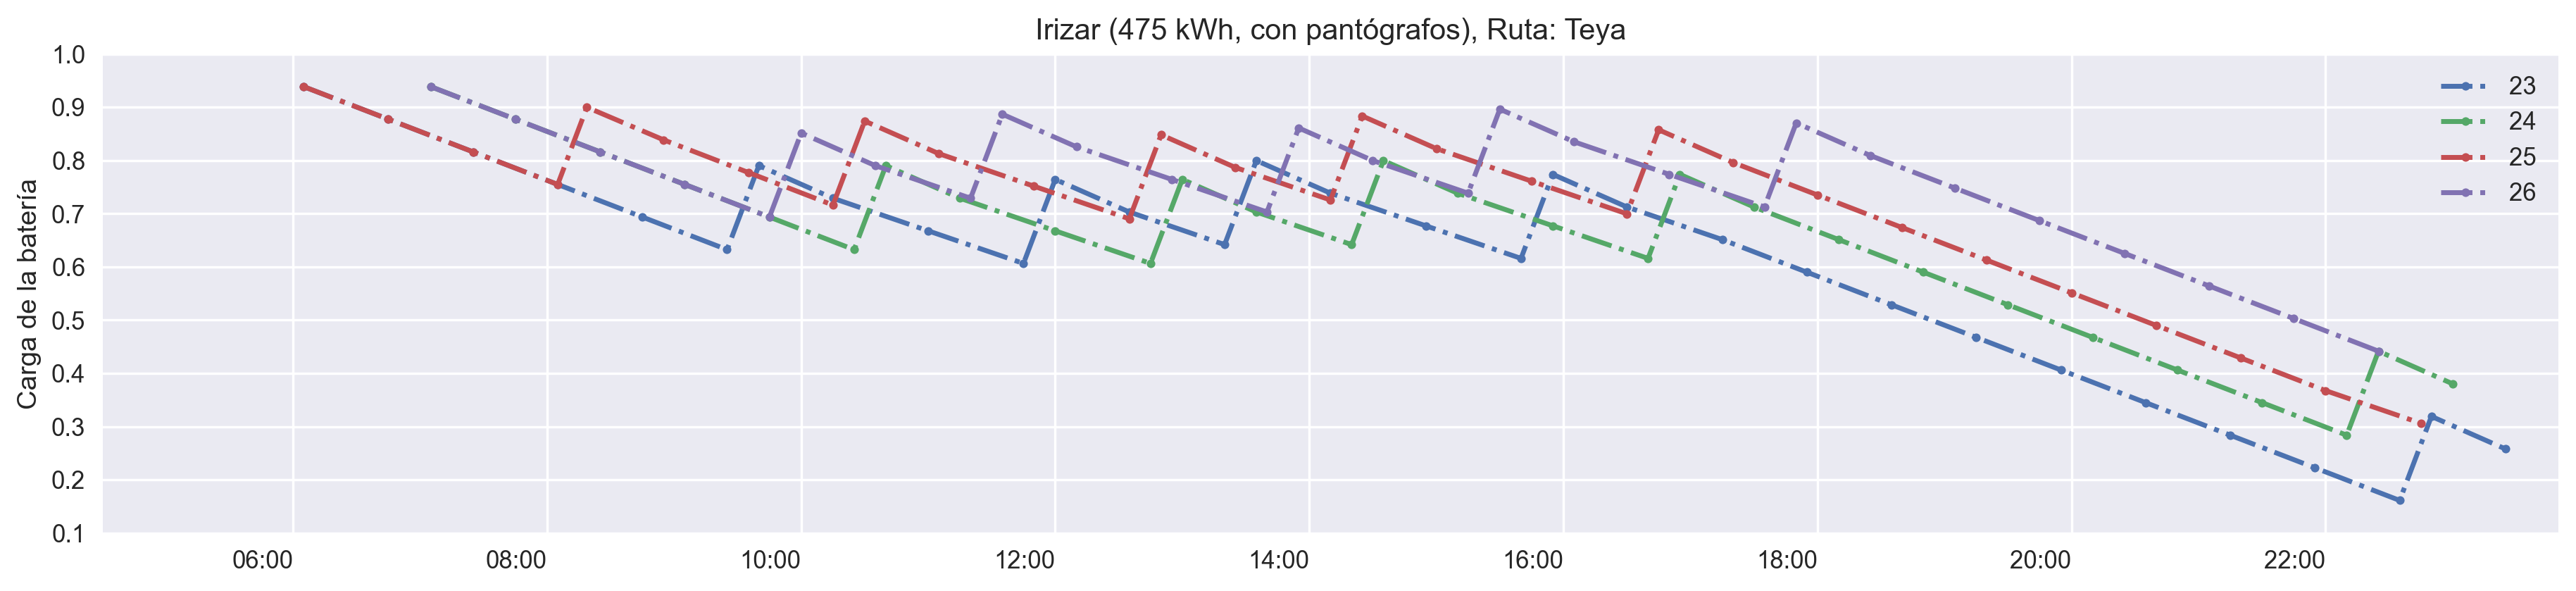

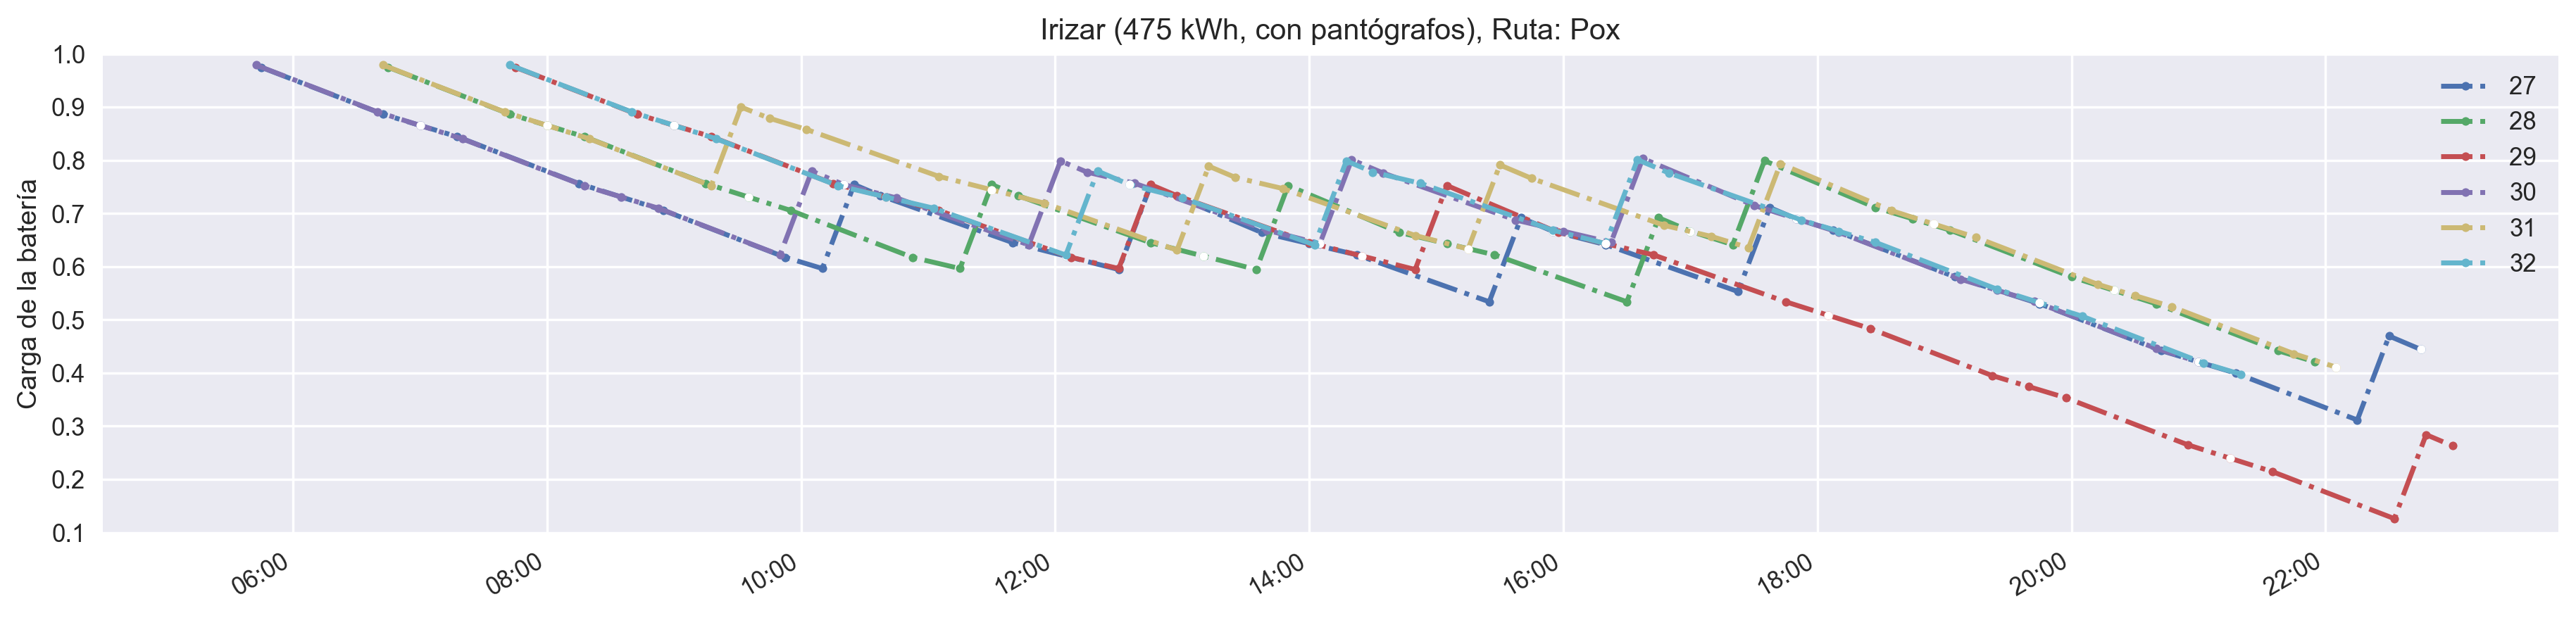

In [7]:
for route in ['Harbor','Kanasin','Uman','Teya','Pox']:
    plt.subplots(figsize=(18,4), dpi=250)
    for bus in buses[route]:
        SoC_real, SoC_times, LieuDeCharge, ChargerTime = [], [], [], []
        for row in df_route[(df_route['bus']==bus)].values : #&(df_route.ruta.isin(or_des[route]))
            SoC_real.append(row[9]); SoC_times.append(row[3])
            if pd.notnull(row[10]):
                SoC_real.append(row[10])
                SoC_times.append(row[3] + pd.to_timedelta(row[6], unit='minutes'))
            if row[1].split('_')[1] == 'POX' :
                LieuDeCharge.append(row[9]); ChargerTime.append(row[3])

        plotter = pd.DataFrame({'soc':SoC_real}, index=SoC_times)
        charger_indicator = pd.DataFrame({'soc':LieuDeCharge}, index=ChargerTime)
        plotter['soc'].plot(lw=2, label=str(bus), style='-.', marker='.')
        charger_indicator['soc'].plot(lw=2, style=' ', marker='.', color='w', label='_nolegend_')
        date_form = DateFormatter("%H:%M"); plt.gca().xaxis.set_major_formatter(date_form)

    plt.title('Irizar ('+ str(batt) + ' kWh, con pantógrafos), Ruta: ' + route ) if Pantographs == True else \
        plt.title('Attivi ('+ str(batt) + ' kWh, sin recargas), Ruta: ' + route )
    plt.ylabel('Carga de la batería'), plt.legend(), plt.style.use('seaborn')
    plt.xlim(['1900-01-01 04:30:00','1900-01-01 23:50:00'])
    plt.xlabel(None) # Para quitar la etiqueta
    plt.ylim([0.1, 1])
    plt.savefig('PLOTS/Irizar.'+ route + '_' + str(batt) +'kWh_recent.png')
plt.show()

[Panel de control](#Panel_de_control)     
[Rol completo](#Rol_completo)         
[Proceso de guardado (compatibilidad)](#Proceso_guardado)   
[Tarifa GDMTH](#GDMTH)     
[Overlaps](#Overlaps)

### CÁLCULO DE BUSES INNECESARIOS <a id='Buses_innecesarios'></a> 

   ###### (No usar formato de compatibilidad)

In [ ]:
# Función para determinar la mejor eliminacion entre los eliminables
# Basado en medidas de tendencia GLOBALES
def moda_viable(modas) :
    df_modas = pd.DataFrame(columns=['mean','min','max','std'])
    for moda in modas :
        aux_buses_necs = buses_necesarios.copy()
        aux_buses_necs.discard(moda)

        df_analisis = df_route[(df_route.bus.isin(aux_buses_necs)) & (df_route['ruta']==estacion)].sort_values('Llegada').reset_index(drop=True).loc[:,['bus','ruta','Salida','Llegada']]
        df_analisis['frecuencia'] = df_analisis.apply(lambda x: frecuencias(df_analisis['Llegada'], x), axis=1)
        df_modas = pd.concat([ df_modas, df_analisis['frecuencia'].agg(['mean','min','max','std']).to_frame().T.reset_index(drop=True)], ignore_index=True) 
        df_modas['bus'] = pd.Series(modas)
    df_modas['diferencias'] = (frec[clave] - df_modas['mean']).abs()
    df_modas = df_modas.sort_values(['max','min','diferencias'], ascending=[True,False,True])

    best_choice = df_modas['bus'][(df_modas['bus']!=buses[clave][0])&(df_modas['bus']!=bus_ruta_inversa[clave][0])].iloc[0]
    best_mean = df_modas['mean'][df_modas['bus']==best_choice].iloc[0]
    best_min = df_modas['min'][df_modas['bus']==best_choice].iloc[0]
    best_max = df_modas['max'][df_modas['bus']==best_choice].iloc[0]
    
    return [best_choice, best_mean, best_min, best_max]

In [72]:
# Función para determinar la mejor eliminacion entre los eliminables
# Basado en frecuencias INDIVIDUALES por evento
def best_disscard(modas, df):
    df_modas = pd.DataFrame(columns=['mean','min','max','std'])
    estadisticas = pd.DataFrame()
    for moda in modas :
        indices = df[df.bus==moda].index
        diffs = []
        for indice in indices :
            try :
                diffs.append( df.frecuencia[indice] + df.frecuencia[indice+1] )
            except :
                pass

        estadisticas = pd.concat([estadisticas, pd.Series(diffs, name=moda)],axis=1)
    estadisticas = estadisticas.agg(['mean','min','max']).T.sort_values(['max','min'], ascending=[True,False])
    #estadisticas['diferencias'] = (frec[clave] - estadisticas['mean']).abs()
    estadisticas.index.name = 'bus'
    estadisticas.reset_index(inplace=True)
    best_choices = estadisticas[(estadisticas.bus!=buses[clave][0])&(estadisticas['bus']!=bus_ruta_inversa[clave][0])].iloc[0]
    return best_choices.values

#best_disscard(eliminables, df_analisis)

In [92]:
full_innecesarios, full_necesarios = [], set()
for destino in or_des.values() :
    estacion = destino[1] if destino!=or_des['Pox'] else destino[-1]   # Selecciona estación
    clave = func_nombres(estacion)
    f = frec[clave]# min(frec[clave], tiempo_ruta[clave])  # EL MÍNIMO ENTRE T_RUTA O FRECUENCIA
    f_promedio, f_max, innecesarios = f, f, []
    buses_necesarios = set(buses[clave])

    while(f_promedio<1.1*f and f_max<1.3*f) :  # f_promedio>0.66*f and f_promedio<1.33*f and f_max<2*f
        try :
            df_analisis = df_route[(df_route.bus.isin(buses_necesarios)) & (df_route['ruta']==estacion)].sort_values('Llegada').reset_index(drop=True).loc[:,['bus','ruta','Salida','Llegada','Vacío']]
            df_analisis['frecuencia'] = df_analisis.apply(lambda x: frecuencias(df_analisis['Llegada'], x), axis=1)
            df_analisis[['Inn 1','Inn 2']] = df_analisis.apply(lambda line: comparaciones(line), axis=1, result_type='expand')

            eliminables = pd.concat([df_analisis['Inn 1'], df_analisis['Inn 2']], ignore_index=True).dropna().unique()
            #break # Usar para analizar la PRIMERA ITERACIÓN
            #moda, f_promedio, f_min, f_max = moda_viable(eliminables)
            moda, f_promedio, f_min, f_max = best_disscard(eliminables, df_analisis)
            if f_max>1.3*f :
                break
            buses_necesarios.remove(moda)
            innecesarios.append(moda)
            full_innecesarios.append(moda)

            print(df_analisis[['bus','ruta','frecuencia']].head())
            print('\nEliminables: ', eliminables,'\nModa: ', moda, '\nEstadísticas de tiempo: ', [round(f_promedio.total_seconds()/60,2), f_min.total_seconds()/60, f_max.total_seconds()/60], '\n')
        except:
            print('Error or finish\n')
            break
    #buses_necesarios.add(int(moda))
    full_necesarios = full_necesarios.union(buses_necesarios)
    print('\tBuses necesarios: ', list(buses_necesarios), '\n\tStarters: ', buses[clave][0],', ', bus_ruta_inversa[clave][0], '\n\tBase frequency: ', frec[clave])
    print('\tBuses innecesarios:', innecesarios, '\n')

    df_analisis = df_analisis[df_analisis.bus.isin(buses_necesarios)].sort_values('Llegada').reset_index(drop=True)
    df_analisis['frecuencia'] = df_analisis.apply(lambda x: frecuencias(df_analisis['Llegada'], x), axis=1)
#print(df_analisis['frecuencia'].agg(['mean','min','max','std']))
print('\tBuses innecesarios full list:', full_innecesarios)
df_analisis.head(5)

	Buses necesarios:  [1, 2, 3, 4, 5, 6, 7] 
	Starters:  1 ,  4 
	Base frequency:  0 days 00:15:00
	Buses innecesarios: [] 

Error or finish
	Buses necesarios:  [8, 9, 10, 11, 12, 13] 
	Starters:  8 ,  12 
	Base frequency:  0 days 00:15:00
	Buses innecesarios: [] 

	Buses necesarios:  [14, 15, 16, 17, 18, 19, 20, 21, 22] 
	Starters:  14 ,  21 
	Base frequency:  0 days 00:15:00
	Buses innecesarios: [] 

   bus     ruta      frecuencia
0   25  PLA_TEY             NaT
1   23  PLA_TEY 0 days 00:40:00
2   26  PLA_TEY 0 days 00:20:00
3   25  PLA_TEY 0 days 00:20:00
4   24  PLA_TEY 0 days 00:20:00

Eliminables:  [23. 26. 25. 24.] 
Moda:  24.0 
Estadísticas de tiempo:  [40.0, 35.0, 45.0] 

   bus     ruta      frecuencia
0   25  PLA_TEY             NaT
1   23  PLA_TEY 0 days 00:40:00
2   26  PLA_TEY 0 days 00:20:00
3   25  PLA_TEY 0 days 00:20:00
4   23  PLA_TEY 0 days 00:40:00

Eliminables:  [23. 26. 25.] 
Moda:  26.0 
Estadísticas de tiempo:  [46.36, 40.0, 50.0] 

Error or finish
	Buses necesa

,bus,ruta,Salida,Llegada,Vacío,frecuencia,Inn 1,Inn 2
0,30,CCO_POX,1900-01-01 06:15:00,1900-01-01 06:55:00,False,NaT,NaN,NaN
1,31,CCO_POX,1900-01-01 07:15:00,1900-01-01 07:55:00,False,0 days 01:00:00,NaN,NaN
2,27,CCO_POX,1900-01-01 07:45:00,1900-01-01 08:25:00,False,0 days 00:30:00,31.0,27.0
3,28,CCO_POX,1900-01-01 08:45:00,1900-01-01 09:25:00,False,0 days 01:00:00,NaN,NaN
4,30,CCO_POX,1900-01-01 09:15:00,1900-01-01 09:55:00,False,0 days 00:30:00,28.0,30.0


   ###### Eliminando los buses del rol general

In [ ]:
if False :  # Cambiar a True si se quieren eliminar los buses innecesarios
    df_route = df_route[df_route.bus.isin(full_necesarios)]
df_route.head()

   ###### Estadísticas nuevas

In [133]:
for destino in or_des.values() :
    df_analisis_final = df_route[(df_route['ruta']==destino[1])].sort_values('Llegada').reset_index(drop=True).loc[:,['bus','ruta','Salida','Llegada','Vacío']]
    df_analisis_final['frecuencia'] = df_analisis_final.apply(lambda x: frecuencias(df_analisis_final['Llegada'], x), axis=1)
    print(destino, ':\n', df_analisis_final['frecuencia'].agg(['mean','min','max']), '\n')

['HAR_PLA', 'PLA_HAR'] :
 mean   0 days 00:15:46.363636363
min              0 days 00:02:00
max              0 days 00:30:00
Name: frecuencia, dtype: timedelta64[ns] 

['KAN_PLA', 'PLA_KAN'] :
 mean   0 days 00:22:36.250000
min           0 days 00:15:00
max           0 days 01:05:00
Name: frecuencia, dtype: timedelta64[ns] 

['UMA_PLA', 'PLA_UMA'] :
 mean   0 days 00:17:32.727272727
min              0 days 00:00:00
max              0 days 01:05:00
Name: frecuencia, dtype: timedelta64[ns] 

['TEY_PLA', 'PLA_TEY'] :
 mean   0 days 00:22:20.425531914
min              0 days 00:10:00
max              0 days 00:40:00
Name: frecuencia, dtype: timedelta64[ns] 

['POX_CCO', 'CCO_PLA', 'PLA_CCO', 'CCO_POX'] :
 mean   0 days 00:33:10
min    0 days 00:20:00
max    0 days 01:00:00
Name: frecuencia, dtype: timedelta64[ns] 



### PROCESAMIENTO PARA GUARDADO <a id='Proceso_guardado'></a>

   ###### Formato de compatibilidad

In [166]:
def formato(fila):
    salida = fila['Salida'].strftime('%H:%M')
    llegada = fila['Llegada'].strftime('%H:%M')
    soc_arriv = round(float(fila['SoC_llegada']), 3)
    soc_depar = round(float(fila['SoC_salida']), 3)
    t_recorrido = fila['Tiempo recorrido'].split(':')[0] +':'+ fila['Tiempo recorrido'].split(':')[1]
    return [salida,llegada,soc_arriv,soc_depar,t_recorrido]

df_route[['Salida','Llegada','SoC_llegada','SoC_salida','Tiempo recorrido']] = df_route.apply(lambda line: formato(line), axis=1, result_type='expand')

   ###### Exportando la tabla de datos

In [167]:
exportar = True

if Pantographs == False :
    df_route = df_route.loc[:,['bus','ruta','Vacío','Salida','Llegada','km','km acum','Tiempo recorrido','T_espera','SoC_llegada','SoC_salida']]
if exportar == True :
    df_route.to_csv('FILES/ASP_FILES/RolAutobuses_allRoutes_(ASPv3.4).csv', encoding='utf-8-sig', index = False)

### TARIFA GDMTH <a id='GDMTH'></a>

   ###### Cálculos de consumos diurno y nocturno 
   (Sin formato de compatibilidad)

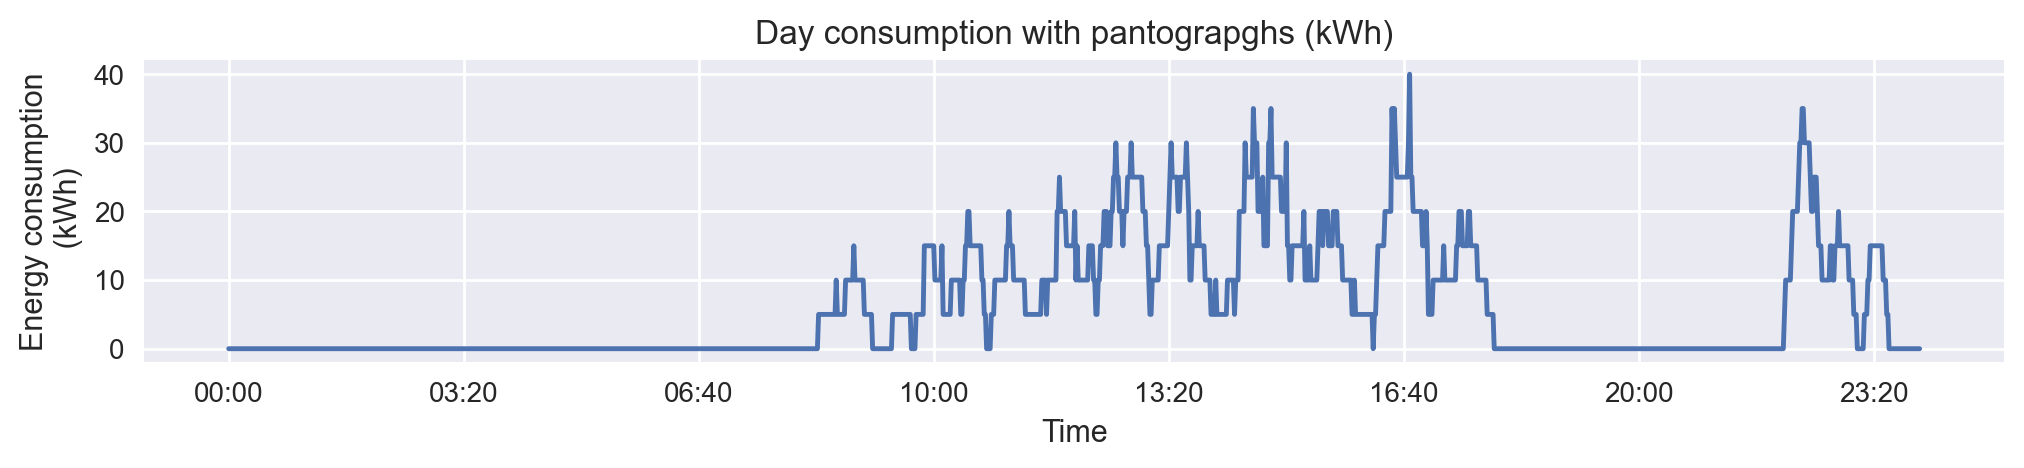

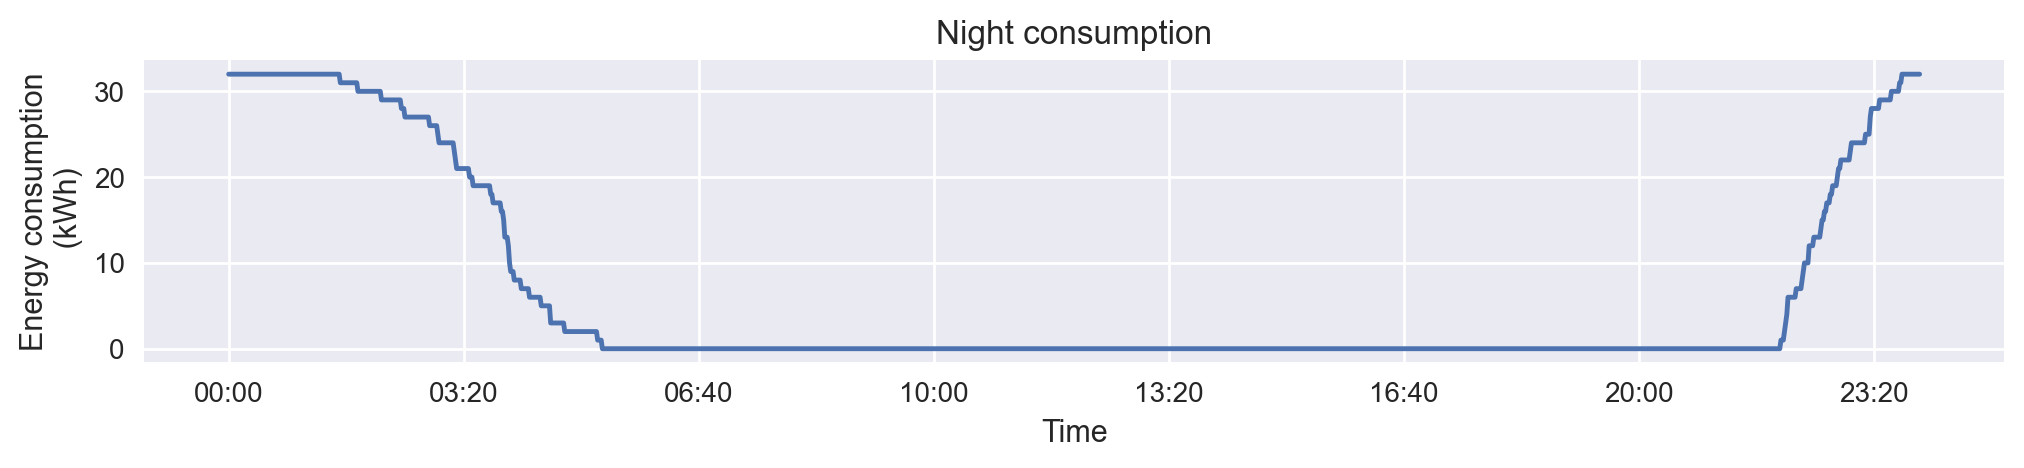

In [72]:
df_allProfiles_night, df_allProfiles_day = pd.DataFrame(), pd.DataFrame()

for route in ['Harbor','Kanasin','Uman','Teya','Pox']:
# CARGA NOCTURNA
    lastCharges = []
    for bus in buses[route] :
        # Selecciona la última hora de llegada y la salida inicial para obtener los límites de carga
        busSchedule = df_route[df_route['bus']==bus].loc[:,['bus','ruta','Salida','Llegada','SoC_llegada']]
        first_salida, last_llegada = busSchedule.iloc[0,2], busSchedule.iloc[-1,3]
        lastCharges.append([bus, busSchedule.iloc[0,1], first_salida, last_llegada, busSchedule.iloc[-1,-1]])
    df_lastCharges = pd.DataFrame(lastCharges, columns = ['bus','ruta','Salida','Llegada','SoC_llegada'])
    # Definimos la columna de la cantidad de energía a cargar
    df_lastCharges['Carga'] = df_lastCharges['SoC_llegada'].apply(lambda soc: batt*(1-soc))
    # Agregamos las columnas de tiempos 
    df_lastCharges[['Tiempo carga','Hora fin','Carga total']] = df_lastCharges.apply(lambda line: tiempos_carga(line[3], line[2], line[5]), axis=1, result_type='expand')
    # Generamos un dataframe vacío en un intervalo de todo el día para graficar después
    energy_night = pd.DataFrame({'Hora': pd.date_range(start='00:00:00', end='23:59:00', 
                                freq='Min').strftime('%H:%M').to_list()}).set_index('Hora')
    for line in df_lastCharges.values :
        try:
            column = str(line[0]) +'_'+ line[1]
            energy_night[column] = 0
            energy_night[column].loc['00:00':line[-2].time().strftime('%H:%M')] = 1
            energy_night[column].loc[line[3].time().strftime('%H:%M'):'23:59'] = 1   
        except:
            print(column, 'has a problem with night charge schedule')
    # Se suma la cantidad de buses cargándose al mismo tiempo en intervalos de 1 minuto
    energy_night['suma'] = energy_night.apply(lambda line : line.sum(), axis=1)
    df_allProfiles_night[route] = energy_night['suma']
    
    
# CARGA DIURNA
    df_dayCharges = df_route[(df_route.Cargador!='')&(df_route.bus.isin(buses[route]))].loc[:,['bus','ruta','Llegada','T_espera','T_carga','Cargador','Potencia_cargador','SoC_llegada','SoC_salida']]
    # Creamos la columna de salida (fin carga) según el tiempo de carga en la estación
    df_dayCharges['Fin Carga'] = df_dayCharges.apply(lambda line: finCarga(line[2], line[4]), axis=1 )
    # Generamos un dataframe vacío en un intervalo de todo el día para graficar después
    energy_day = pd.DataFrame(columns = np.arange(1,33), index=pd.date_range(start='00:00:00', 
                              end='23:59:00', freq='Min').strftime('%H:%M').to_list())
    for line in df_dayCharges.values :
        try:
            column = line[0]
            energy_day[column].loc[line[2].time().strftime('%H:%M'):line[-1]] = line[6]/60 # kWh
        except:
            print(column, 'has a problem with night charge schedule')
    energy_day.fillna(0, inplace=True)
    energy_day['suma'] = energy_day.apply(lambda line : line.sum(), axis=1)
    df_allProfiles_day[route] = energy_day['suma']


# Convertimos el dataframe nocturno en términos de energía
df_allProfiles_night = df_allProfiles_night * P_carga_noct/60  # kWh
# Agregamos cada perfil de ruta a un solo dataframe y sumamos el total
df_allProfiles_night['All_routes'] = df_allProfiles_night.apply(lambda line : line.sum(), axis=1)
df_allProfiles_day['All_routes'] = df_allProfiles_day.apply(lambda line : line.sum(), axis=1)

# Plots de gráficas
plt.figure(figsize=(12,2), dpi=200)
df_allProfiles_day['All_routes'].plot()
plt.style.use('seaborn'), plt.title('Day consumption with pantograpghs (kWh)')
plt.ylabel('Energy consumption\n (kWh)'), plt.xlabel('Time')

plt.figure(figsize=(12,2),dpi=200)
df_allProfiles_night['All_routes'].plot()  # Cambiar a la ruta que se desee graficar o todas con 'All_routes'
plt.style.use('seaborn'), plt.title('Night consumption')
plt.ylabel('Energy consumption\n (kWh)'), plt.xlabel('Time')
plt.show()

###### Consumo Total

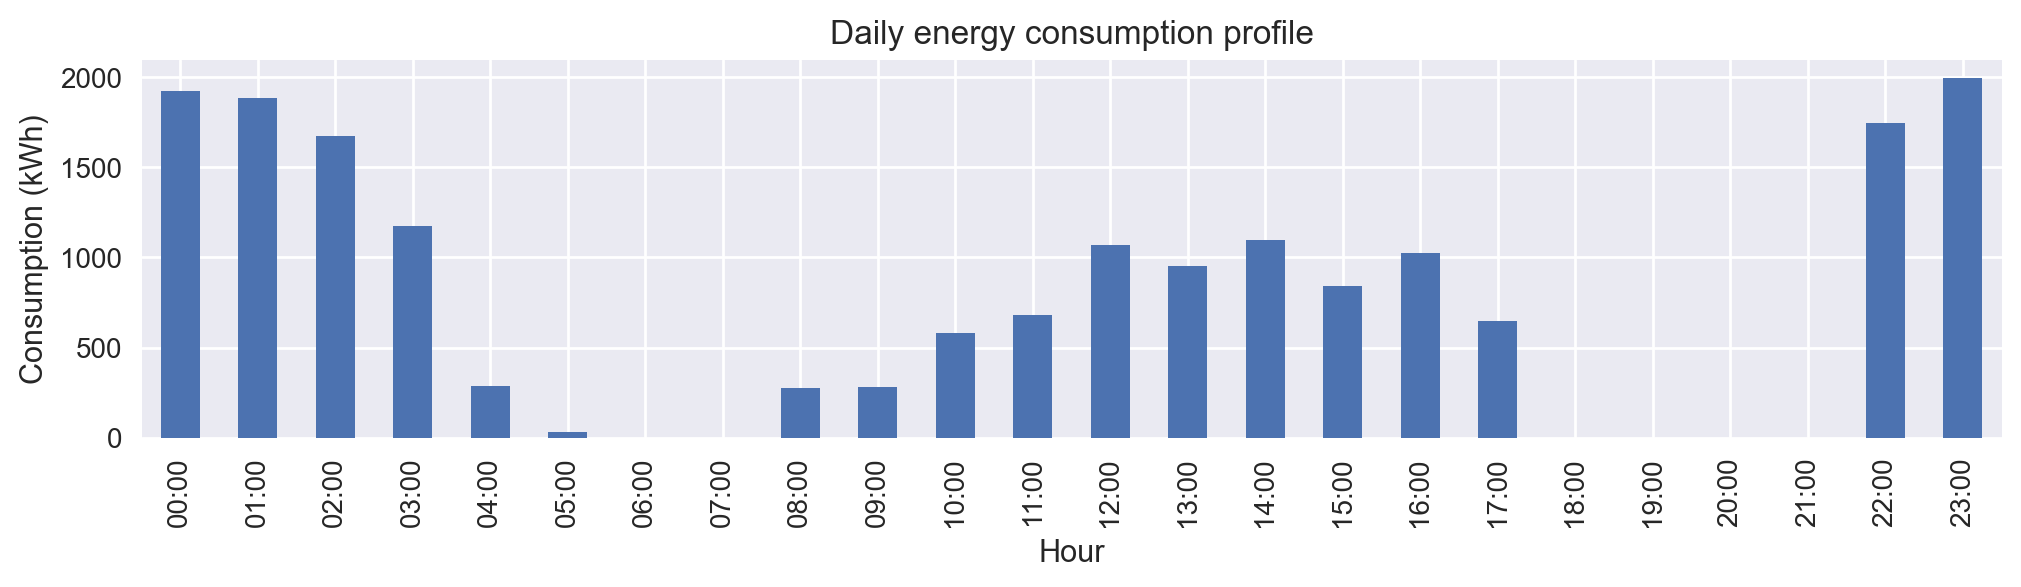

In [73]:
total_consumption = df_allProfiles_night + df_allProfiles_day
total_consumption.index = pd.to_datetime(total_consumption.index)
total_consumption = (total_consumption.resample('60Min').sum()).round(1)
total_consumption.index = total_consumption.index.strftime('%H:%M')

plt.figure(figsize=(12,2.5), dpi=200)
total_consumption['All_routes'].plot.bar() # Indicar la ruta específica o ['All_routes']
plt.ylabel('Consumption (kWh)'); plt.xlabel('Hour')
plt.title('Daily energy consumption profile')
plt.style.use('seaborn')

   ###### Cálculos de la tarifa

In [14]:
# Perfil de consumo cuando se tienen baterías
#perfil = [1200,1200,1200,1200,617,75,0,0,75,370,590,765,980,950,1105,950,1175,800,0,0,0,0,1200,1200]
#total_consumption = pd.DataFrame(pd.Series(data=perfil, index=range(0,24), name='All_routes'))

In [15]:
fijo, dist = 410.63, 99.60
# horario_punta indica T/F si existen consumos en horario punta
#horario_punta = df_route[(df_route['Llegada']>'18:00')&(df_route['Llegada']<'22:00')&(df_route['T_carga']==15)].count().any()
Demanda = int(min(total_consumption['All_routes'].iloc[18:22].max(), total_consumption.values.sum()/(24 * 0.57)))#*horario_punta
tabla_tarifas = []

tarifas = {'Enero':[1.1133, 1.863, 2.077,3,'fuera', 348.36], 'Febrero':[1.1212,1.8774,2.0932,0,'fuera', 351.36],'Marzo':[1.1212,1.8774,2.0932,3,'fuera', 351.36],
          'Abril':[1.1492,1.9282,2.1504,2,'verano', 361.91],'Mayo':[1.1709,1.9674,2.1947,3,'verano', 370.09],'Junio':[1.1402,1.9119,2.1321,2,'verano', 358.52],
          'Julio':[1.1678,1.9617,2.1883,3,'verano', 368.90],'Agosto':[1.1733,1.9717,2.1995,3,'verano', 370.97],'Septiembre':[1.1788,1.9818,2.2109,2,'verano', 373.07],
          'Octubre':[1.1828,1.9889,2.2190,3,'verano', 374.56],'Noviembre':[1.0904,1.8226,2.0316,2,'fuera', 340.22],'Diciembre':[1.1018,1.8433,2.0549,3,'fuera', 344.52]}

for mes in list(tarifas.keys()) :
    b, i, p, dias_extra, clase, cap = tarifas[mes]
    if clase == 'verano' :
        semana = np.concatenate([ b*np.ones(6), i*np.ones(14),p*np.ones(2),i*np.ones(2) ] )
        sabado = np.concatenate([ b*np.ones(7), i*np.ones(17) ] )
        domingo = np.concatenate([ b*np.ones(19), i*np.ones(5) ] )
    else:
        semana = np.concatenate([ b*np.ones(6), i*np.ones(12),p*np.ones(4),i*np.ones(2) ] )
        sabado = np.concatenate([ b*np.ones(8), i*np.ones(11),p*np.ones(2),i*np.ones(3) ] )
        domingo = np.concatenate([ b*np.ones(18), i*np.ones(6) ] )

    entreSemana = (total_consumption['All_routes'] * semana).sum()*(20+dias_extra)
    sabado = (total_consumption['All_routes'] * sabado).sum()*4
    domingo = (total_consumption['All_routes'] * domingo).sum()*4
    cargos = fijo + Demanda*tarifas[mes][5] + Demanda*dist
    
    costo_mensual = (entreSemana + sabado + domingo + cargos).round(2)
    tabla_tarifas.append([mes, costo_mensual])

tarifa_anual = pd.DataFrame(tabla_tarifas, columns=['Mes','Tarifa (MXN)'])
print('Tarifa anual: MXN$', round(tarifa_anual.sum().values[-1],2))
tarifa_anual

Tarifa anual: MXN$ 9115247.63


,Mes,Tarifa (MXN)
0,Enero,753451.97
1,Febrero,683434.59
2,Marzo,759130.63
3,Abril,753288.02
4,Mayo,794687.64
5,Junio,747063.53
6,Julio,792445.29
7,Agosto,796391.60
8,Septiembre,773757.24
9,Octubre,803187.30


In [76]:
# consumo energético anual
print('Consumo energético mensual: ',total_consumption['All_routes'].sum()*30/1000, ' MWh (max. 600MWh)')
print('Consumo energético anual: ',total_consumption['All_routes'].sum()*365/1000, ' MWh')

Consumo energético mensual:  544.47  MWh (max. 600MWh)
Consumo energético anual:  6624.385  MWh


In [77]:
# Perfil de consumos por ruta
total_consumption

,Harbor,Kanasin,Uman,Teya,Pox,All_routes
Hora,,,,,,
00:00,420.0,360.0,540.0,240.0,360.0,1920.0
01:00,420.0,325.0,540.0,240.0,360.0,1885.0
02:00,418.0,190.0,509.0,231.0,327.0,1675.0
03:00,228.0,153.0,336.0,175.0,280.0,1172.0
04:00,34.0,0.0,91.0,69.0,94.0,288.0
05:00,0.0,0.0,0.0,18.0,14.0,32.0
06:00,0.0,0.0,0.0,0.0,0.0,0.0
07:00,0.0,0.0,0.0,0.0,0.0,0.0
08:00,0.0,0.0,160.0,75.0,40.0,275.0


[Panel de control](#Panel_de_control)   
[Rol completo](#Rol_completo)

### OVERLAPS DE CAMIONES <a id='Overlaps'></a>

###### Cargas por cargador

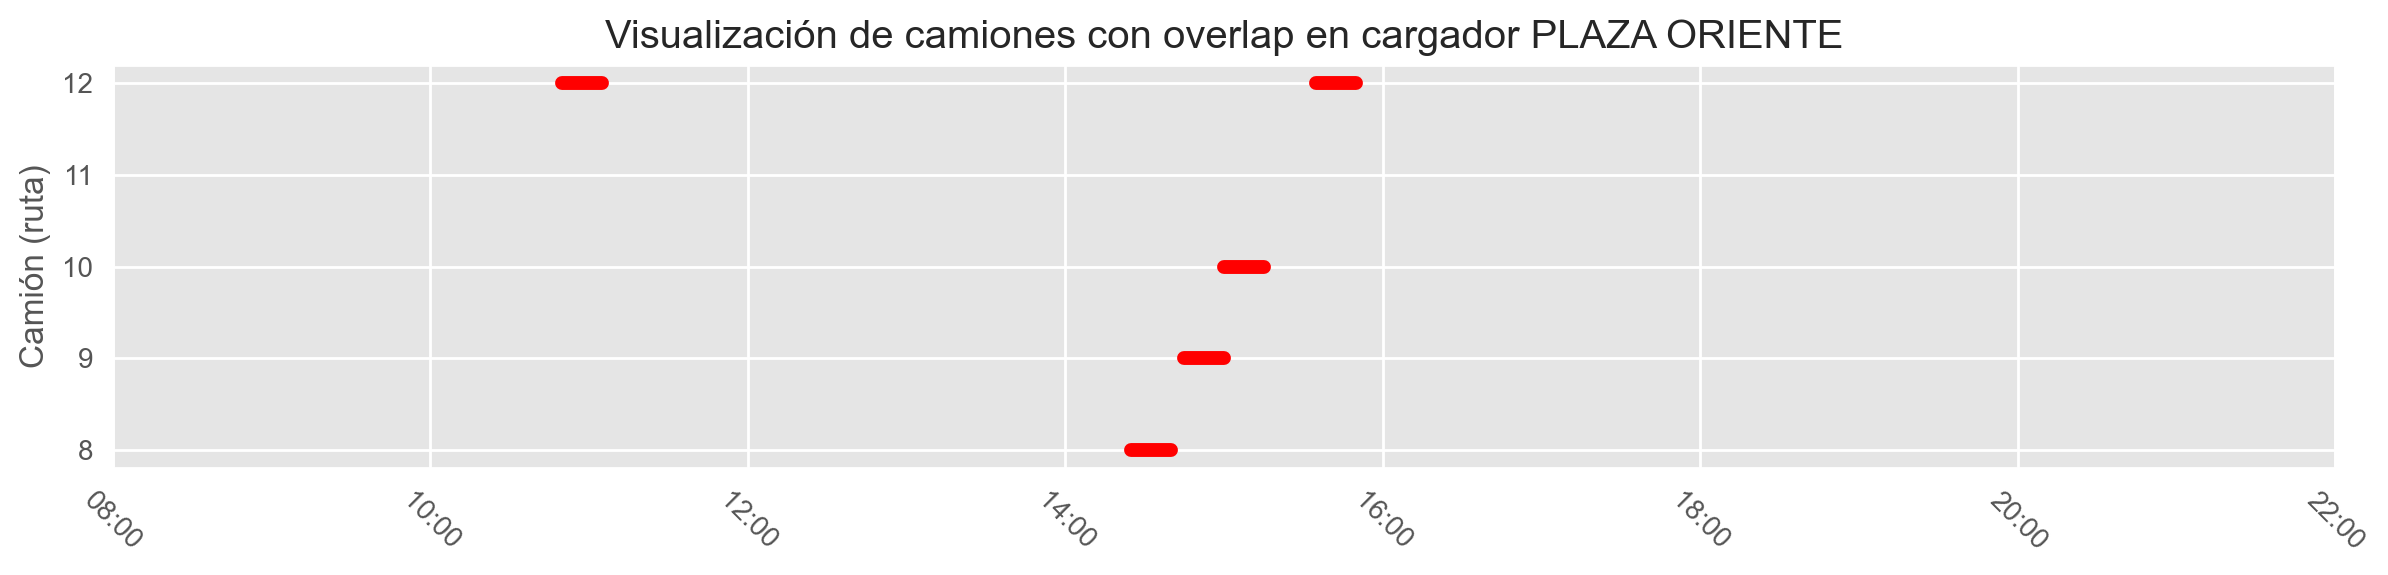

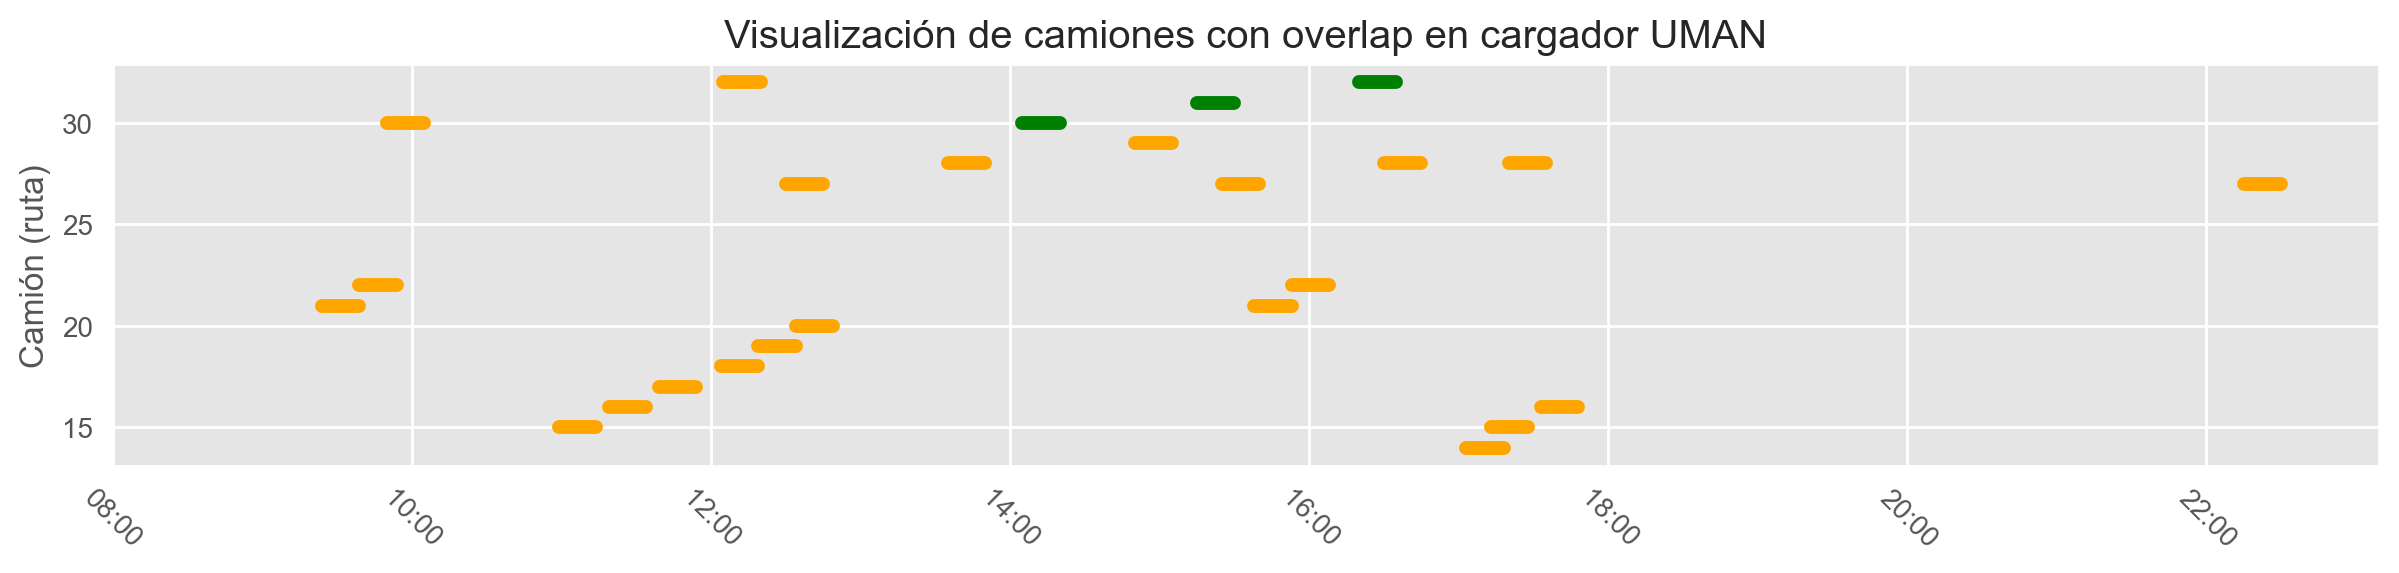

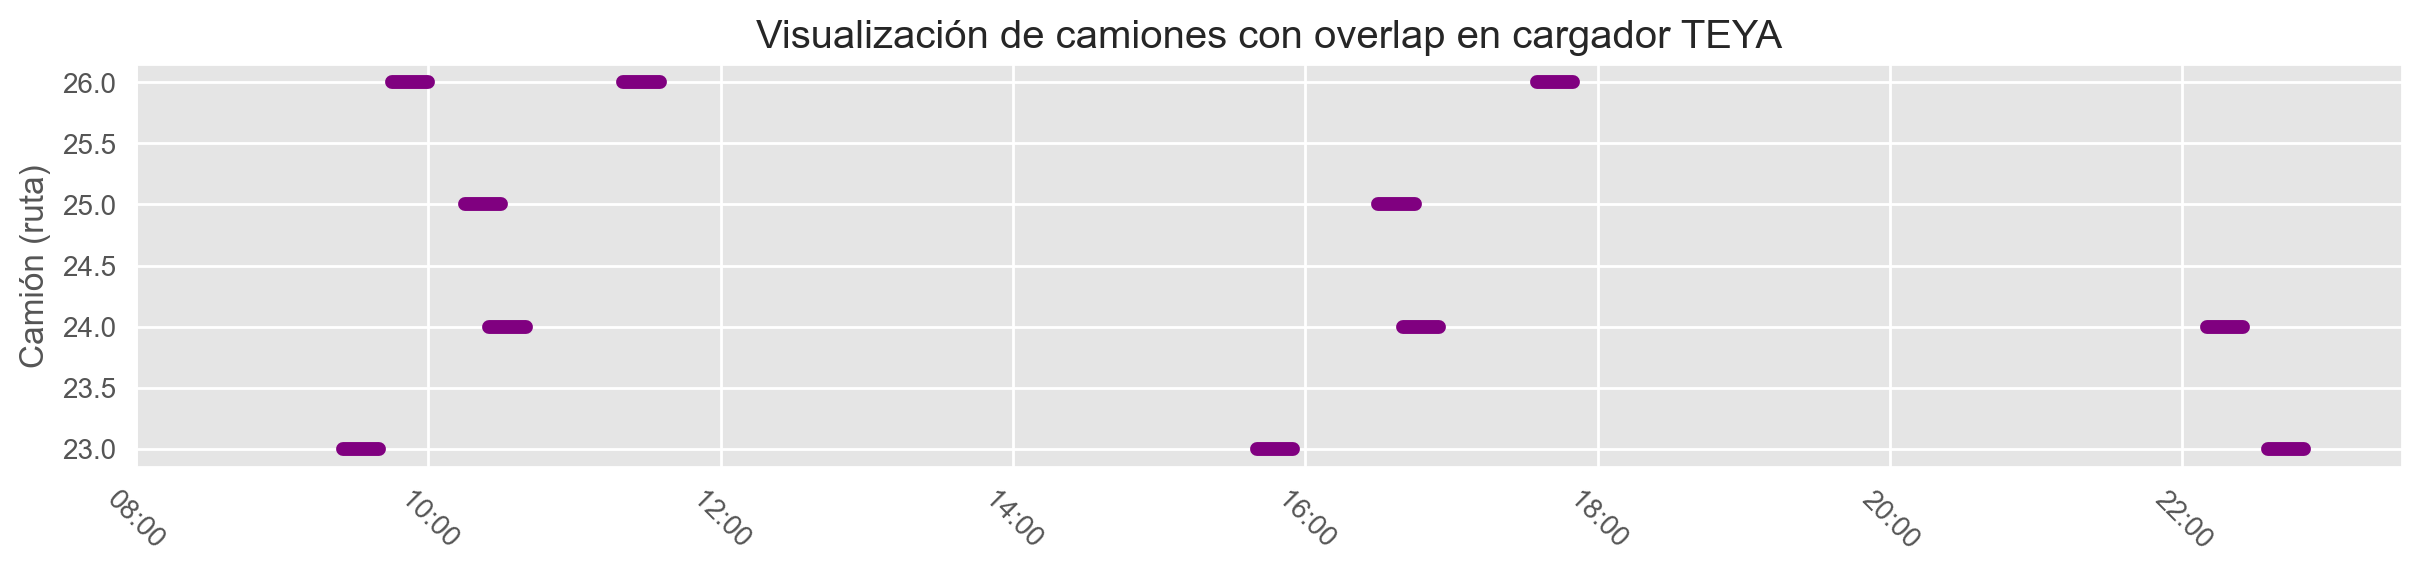

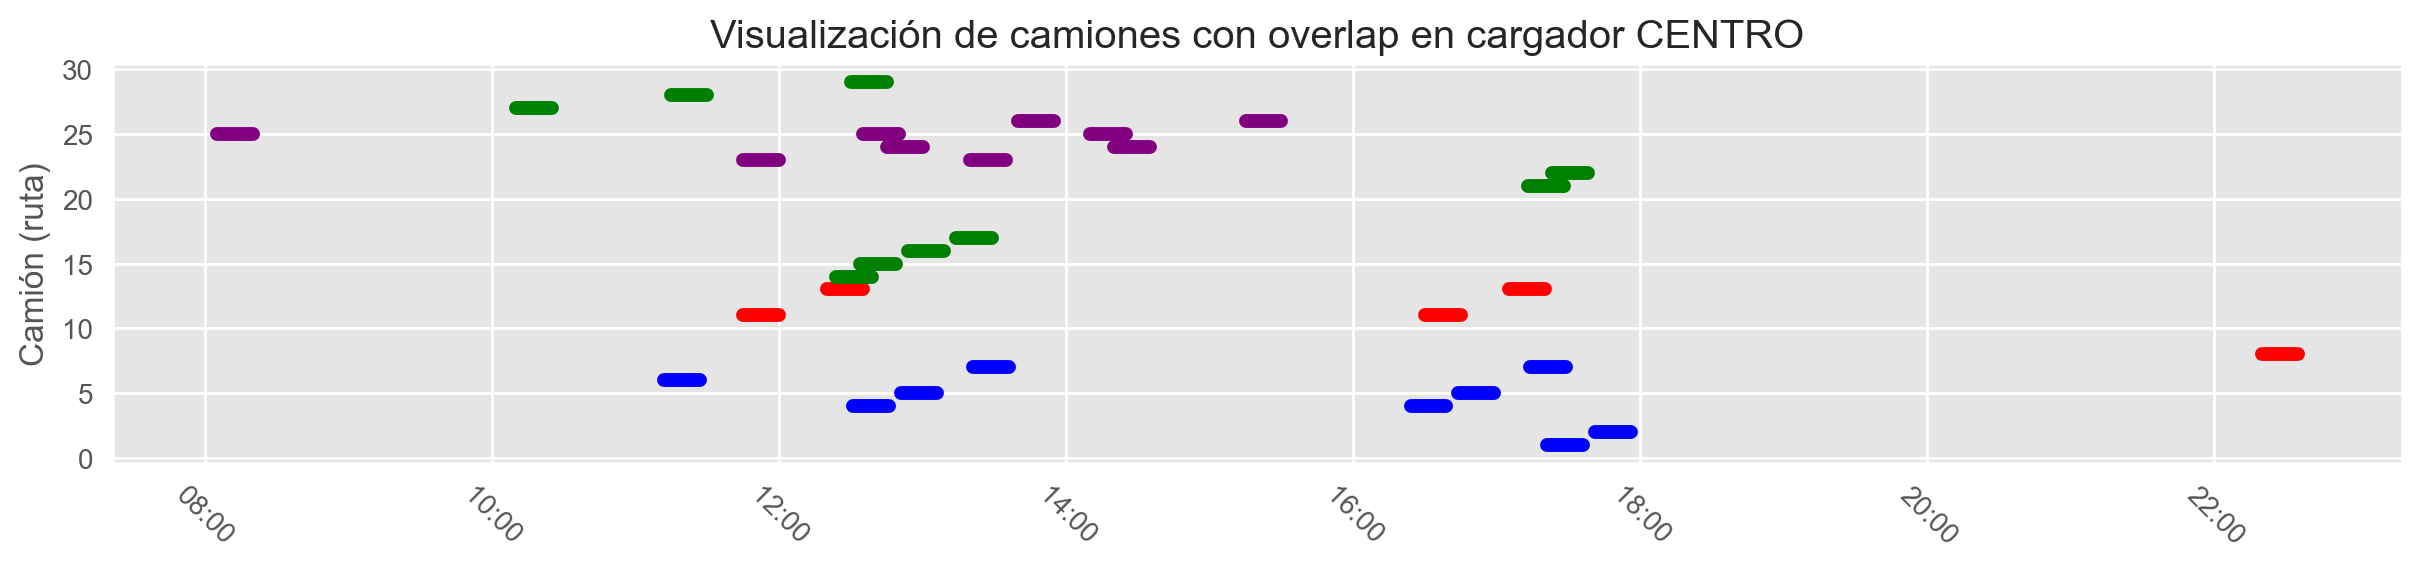

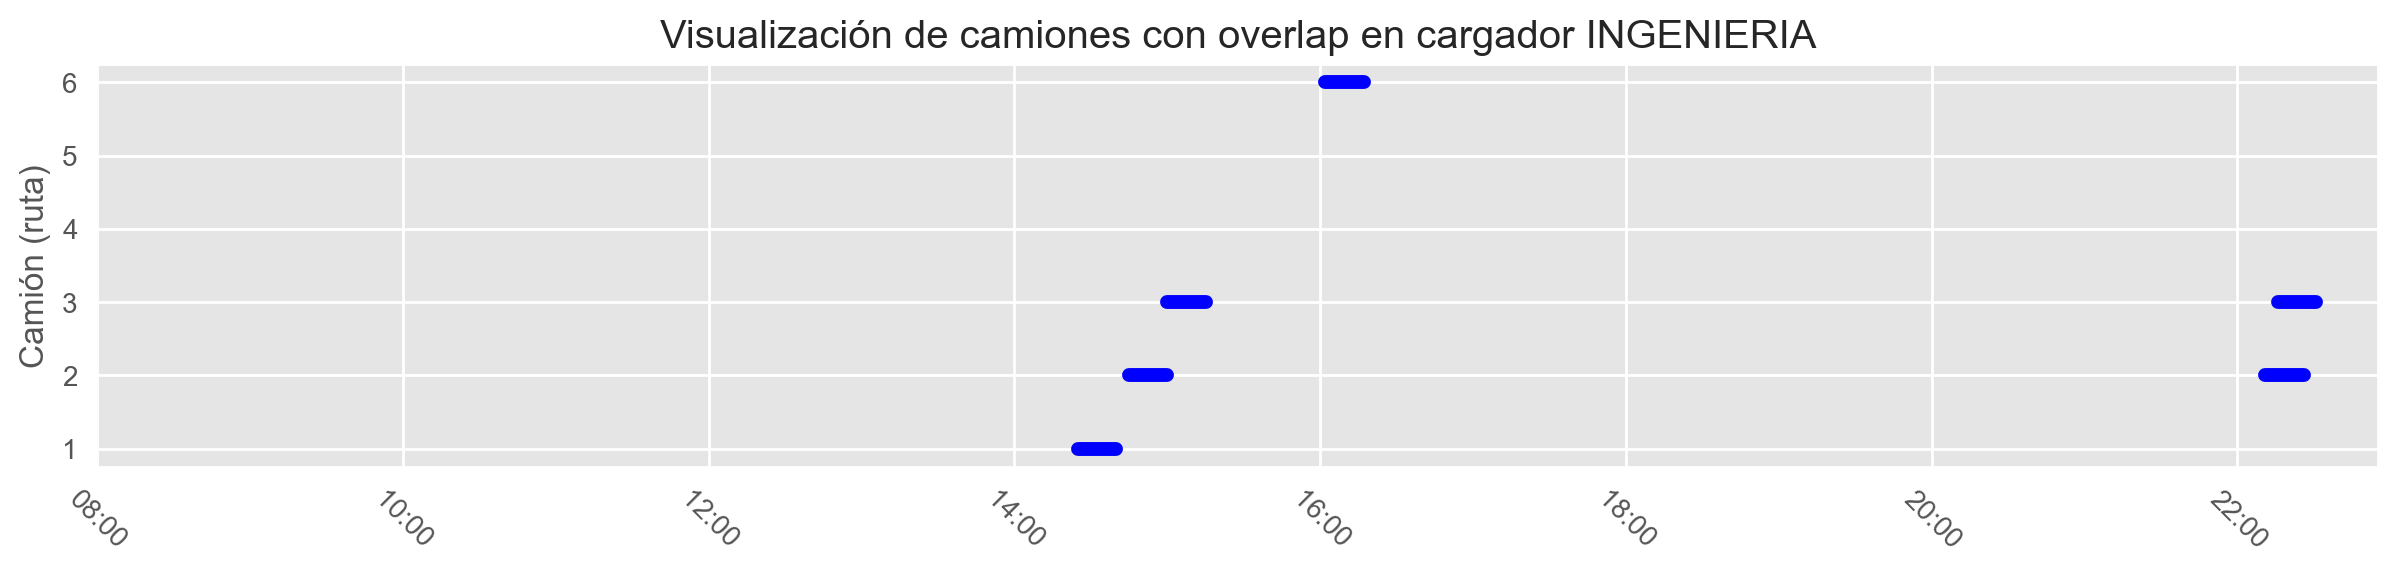

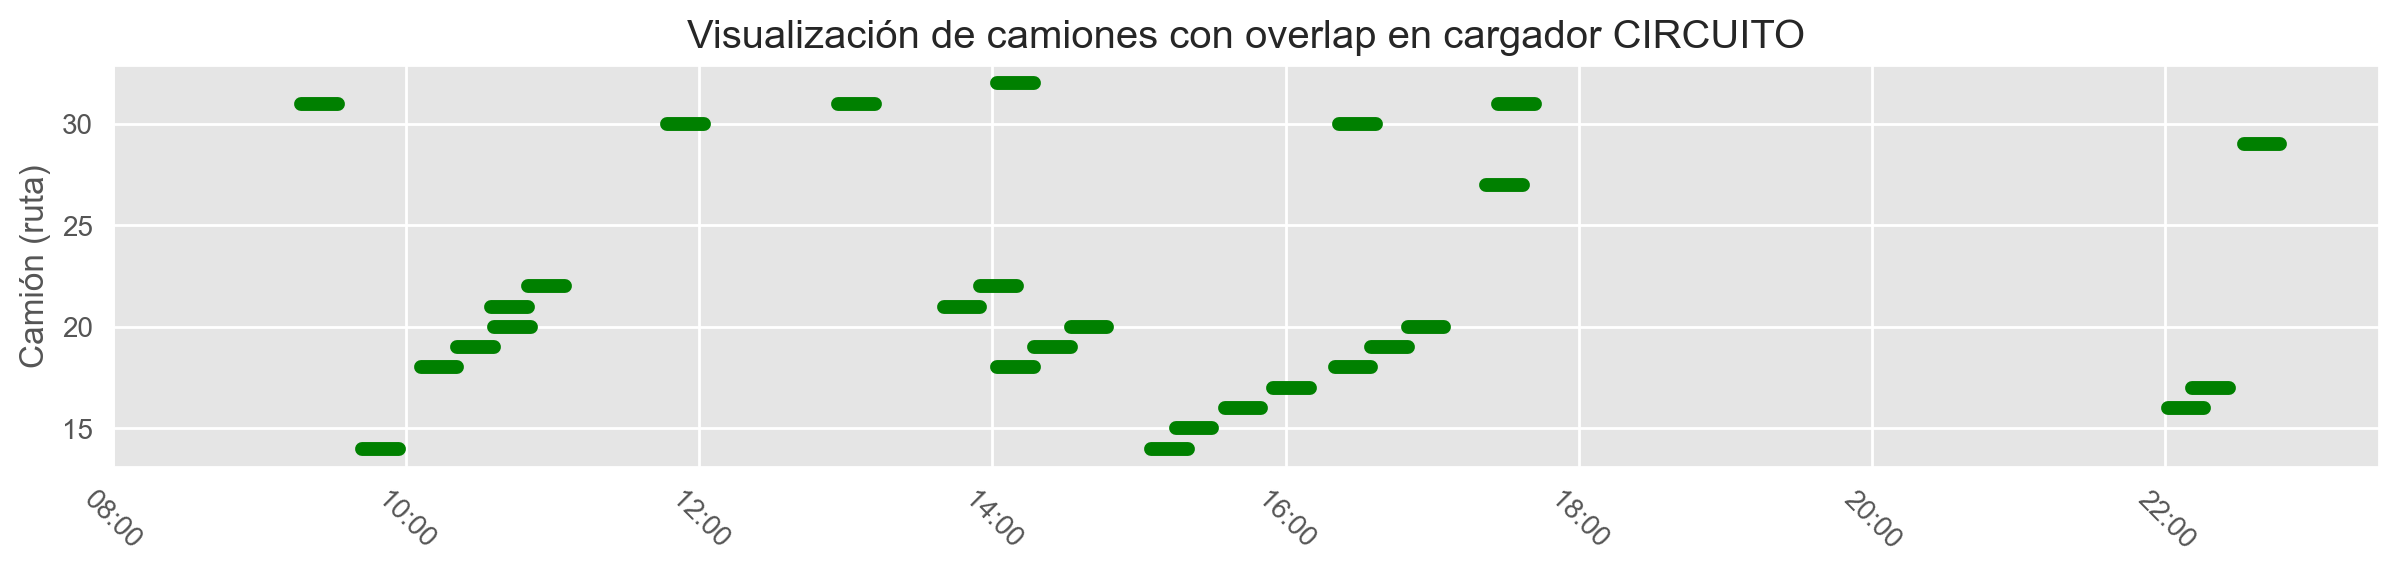

In [186]:
# EVALUACIÓN DE OVERLAPS POR CARGADOR
lista_cargadores = set()
for charger in cargadores.values() :
    if charger[0] not in lista_cargadores :
        lista_cargadores.add(charger[0])
        fig, ax = plt.subplots(1, 1, figsize=(12,3), dpi=200)
        df_dayCharges = df_route[df_route.Cargador==charger[0]].loc[:,['bus','ruta','Llegada','T_espera','T_carga','Cargador','SoC_llegada','SoC_salida']]
        # Creamos la columna de salida (fin carga) según el tiempo de carga en la estación
        df_dayCharges['Fin Carga'] = df_dayCharges.apply(lambda line: finCarga(line[2], line[4]), axis=1 )
        # Generamos un dataframe vacío en un intervalo de todo el día para graficar después
        for line in df_dayCharges.values :
            idx1 = pd.date_range(line[2].time().strftime('%H:%M'), line[-1], freq='min')
            ax.plot(idx1, np.ones(len(idx1))*line[0], lw=5, label=str(line[0])+line[1], color=colores[line[1].split('_')[1] if charger[0]!='CENTRO' else line[1].split('_')[0]])

        plt.style.use('ggplot')
        plt.xticks(pd.date_range(start='08:00:00', end='23:59:00', freq='2H'), rotation=-45)
        plt.tight_layout()
        plt.title('Visualización de camiones con overlap en cargador ' + charger[0])
        plt.ylabel('Camión (ruta)')
        date_form = DateFormatter('%H:%M')
        plt.gca().xaxis.set_major_formatter(date_form)
    else :
        pass

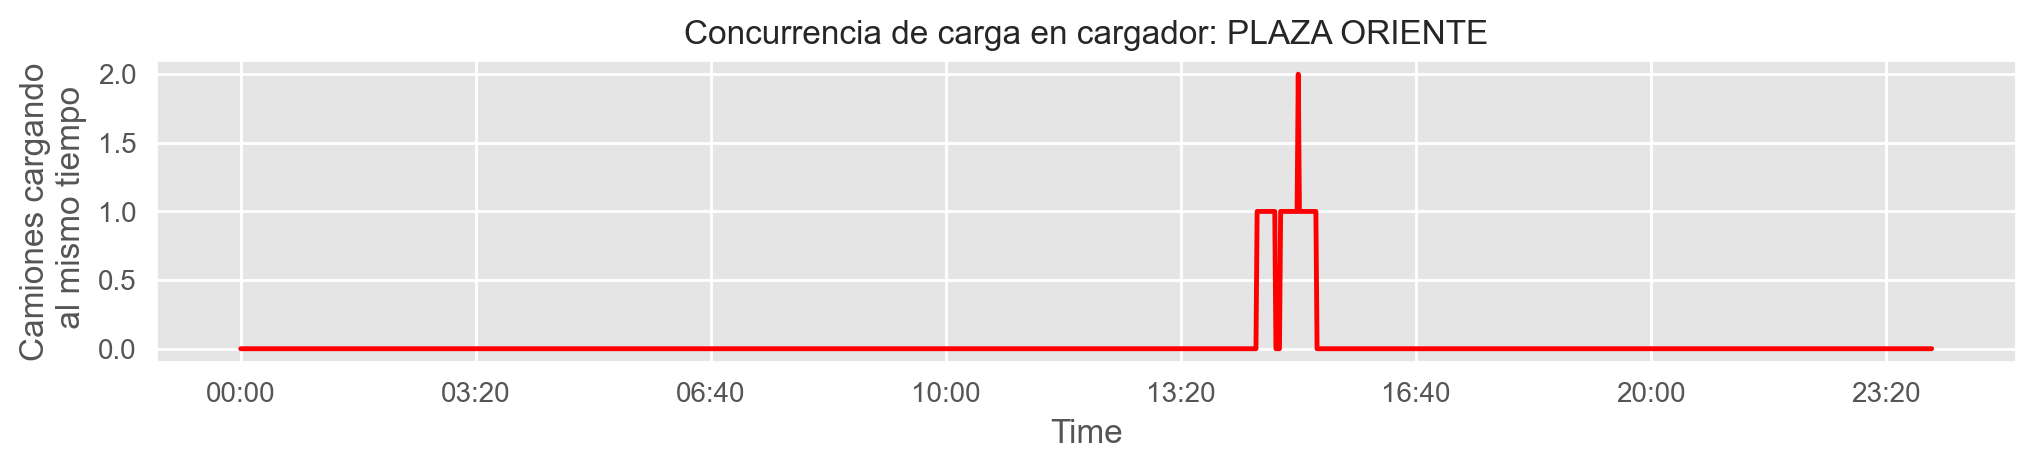

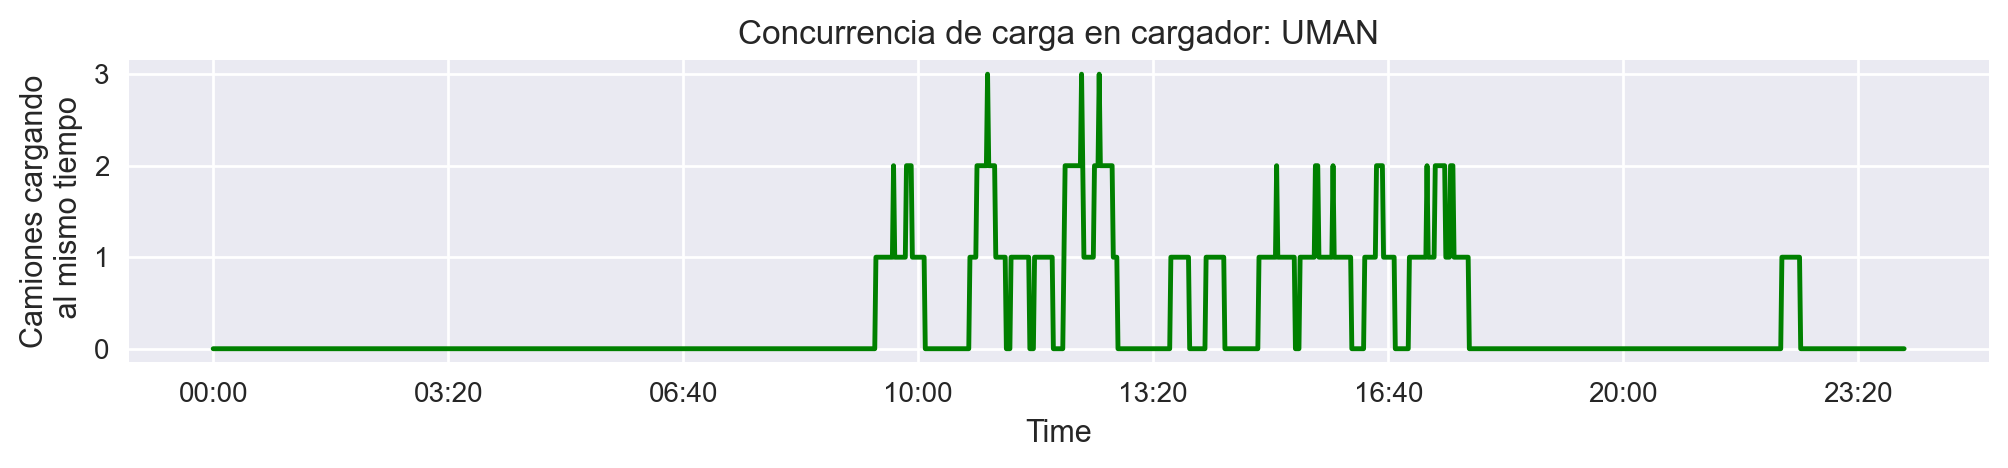

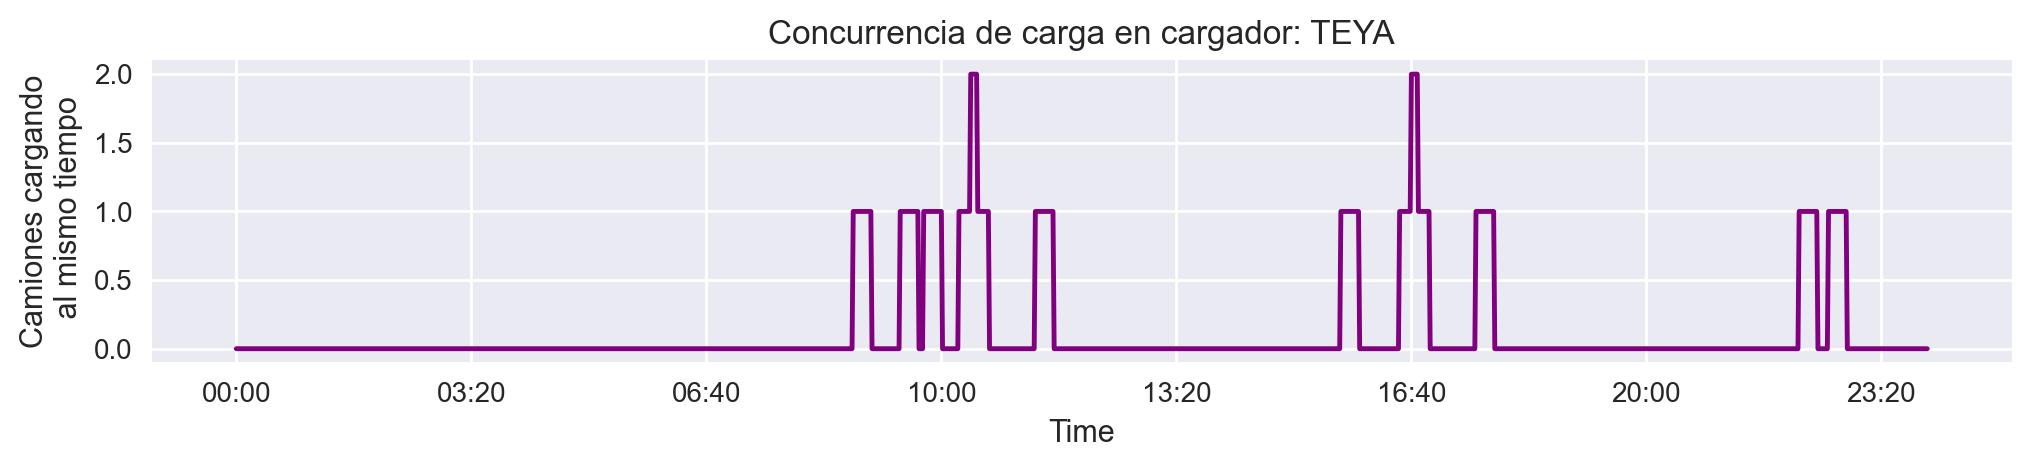

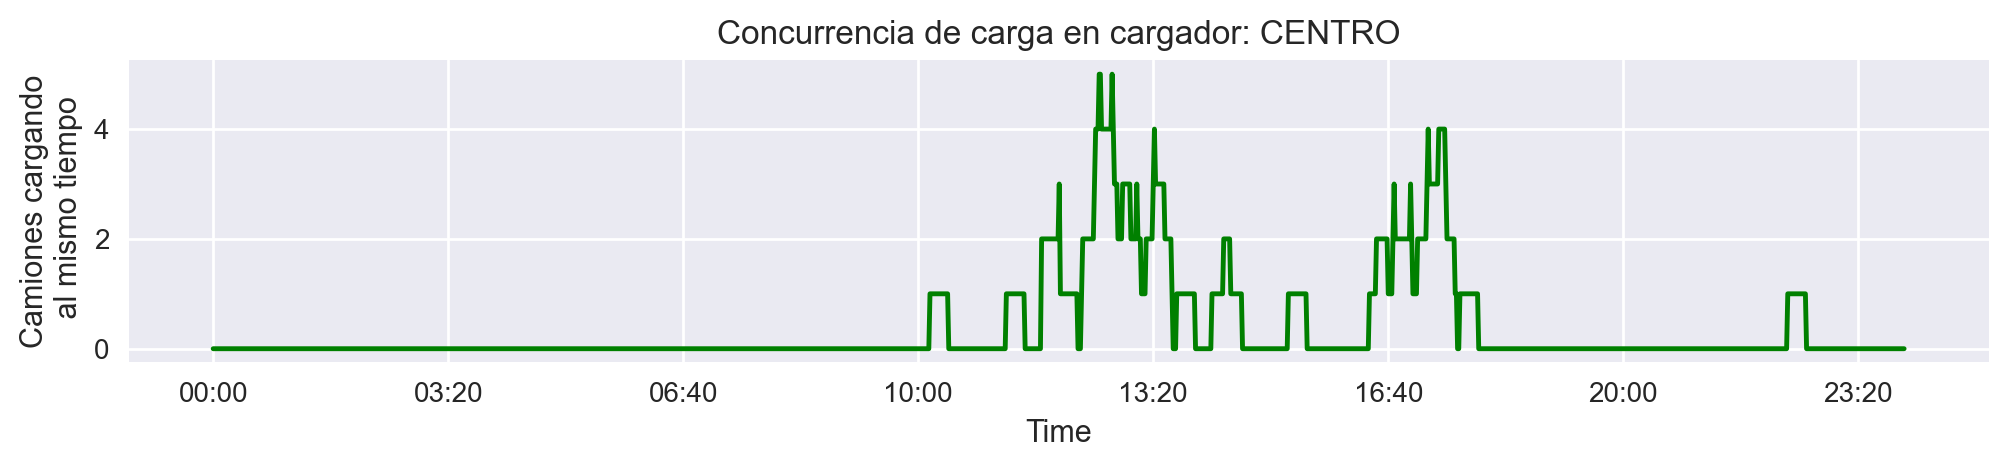

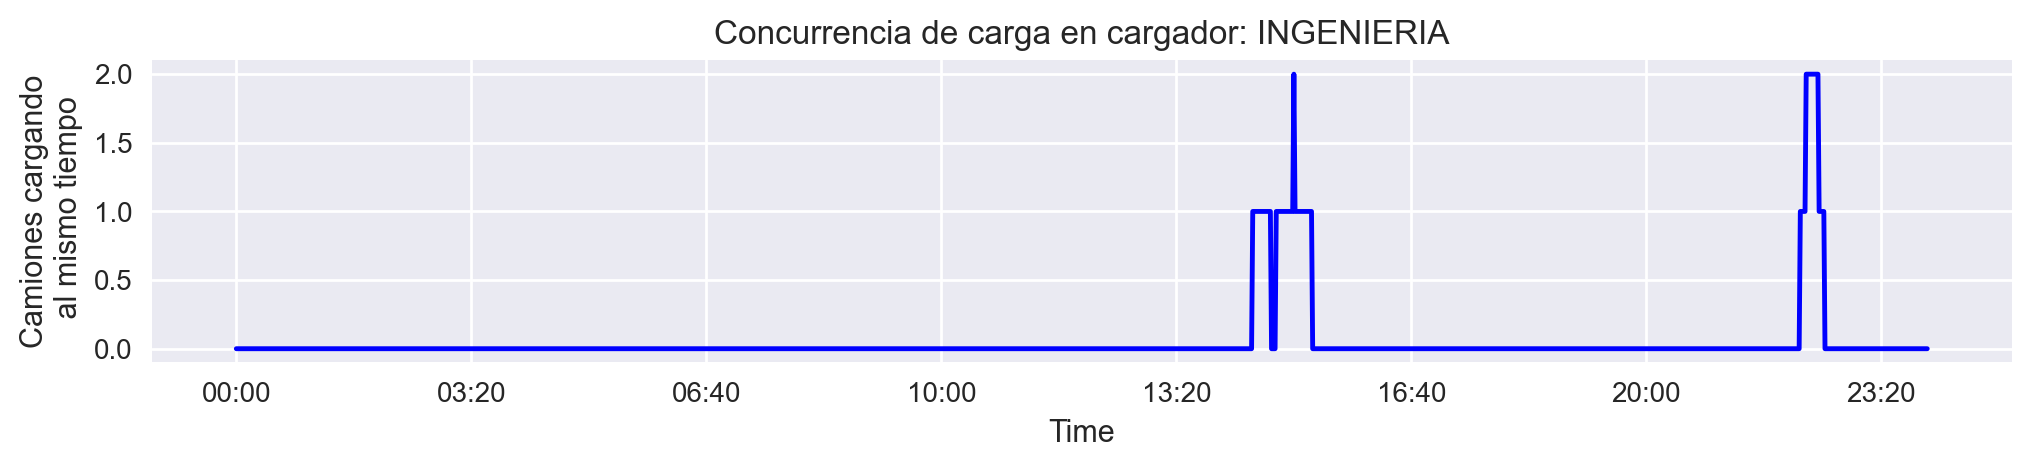

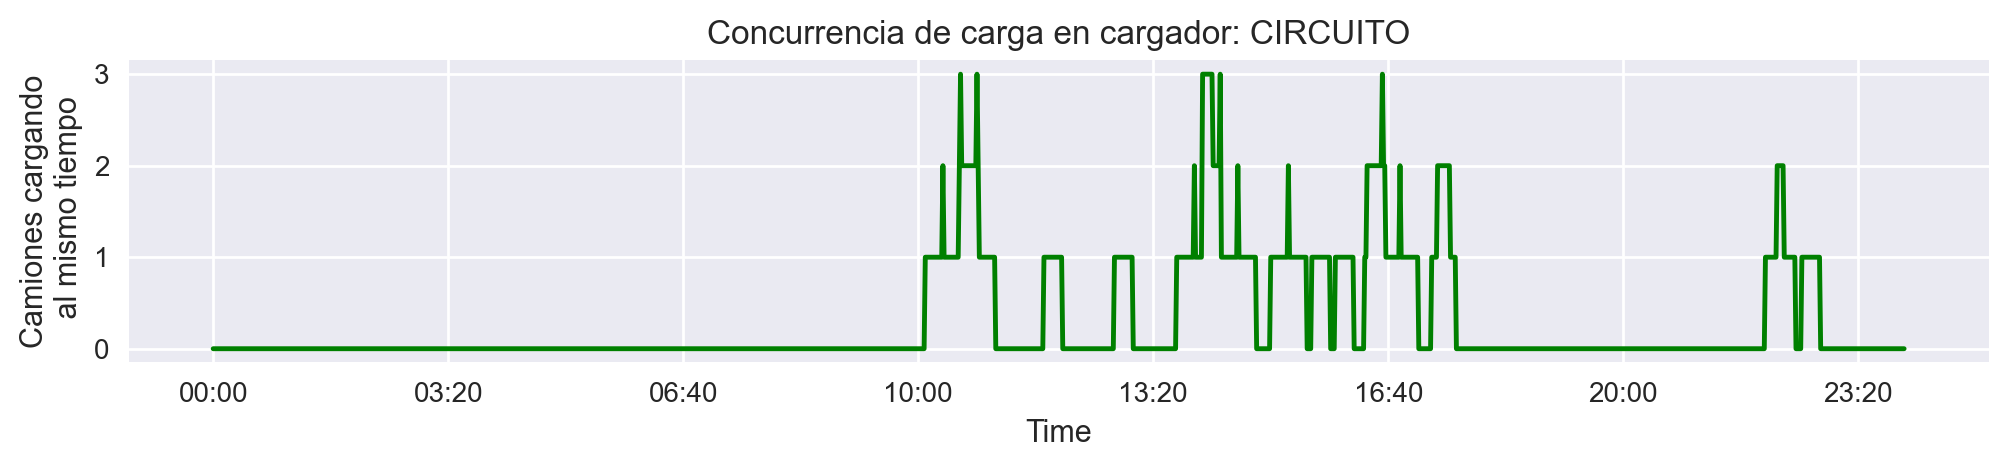

In [148]:
df_allChargers, lista_cargadores = pd.DataFrame(), set()
for charger in cargadores.values() :
    if charger[0] not in lista_cargadores :
        lista_cargadores.add(charger[0])
        df_dayCharges = df_route[df_route.Cargador==charger[0]].loc[:,['bus','ruta','Llegada','T_espera','T_carga','Cargador','SoC_llegada','SoC_salida']]
        # Creamos la columna de salida (fin carga) según el tiempo de carga en la estación
        df_dayCharges['Fin Carga'] = df_dayCharges.apply(lambda line: finCarga(line[2], line[4]), axis=1 )
        # Generamos un dataframe vacío en un intervalo de todo el día para graficar después
        energy_day = pd.DataFrame(columns = np.arange(1,33), index=pd.date_range(start='00:00:00', 
                                  end='23:59:00', freq='Min').strftime('%H:%M').to_list())
        for line in df_dayCharges.values :
            try:
                column = line[0]
                energy_day[column].loc[line[2].time().strftime('%H:%M'):line[-1]] = 1
            except:
                print(column, 'has a problem with night charge schedule')
        energy_day.fillna(0, inplace=True)
        energy_day['suma'] = energy_day.apply(lambda line : line.sum(), axis=1)
        df_allChargers[charger[0]] = energy_day['suma']

        plt.figure(figsize=(12,2), dpi=200)
        df_allChargers[charger[0]].plot(color=colores[line[1].split('_')[1] if charger[0]!='CENTRO' else line[1].split('_')[0]])
        plt.style.use('seaborn'), plt.title('Concurrencia de carga en cargador: ' + charger[0])
        plt.ylabel('Camiones cargando\n al mismo tiempo'), plt.xlabel('Time')
    else :
        pass

[Panel de control](#Panel_de_control)   
[Rol completo](#Rol_completo)